In [1]:
## Learning how to use Boruta/xgboost/shap to interpret
# upsides
# - xgboost handles missing values
# - xgboost also appears to handle sample weights!
# - shap is great for analysing xgboost (and other) output
# - boostaroota - runs Boruta with xgboost

In [2]:
## TODO

# Boruta.py with xgboost (do we have to use boostaroota? boruta.py is a bit clearer)

# xgboost on dataset with more missing values (redo BES_reduced)

# xgboost automatic tuning
# https://github.com/cwerner87/xgboost-tuner


# t-SNE stuff for high dimensional analsysi?

In [73]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [4]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [5]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [75]:
# del xgboost
xgb_dir = "C:\\Users\\Marios\\AppData\\Local\\conda\\conda\\envs\\BES_analysis\\Lib\\site-packages\\xgboost"
import sys, os
sys.path.append(xgb_dir)
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, cv, plot_tree

# First XGBoost model for Pima Indians dataset
import graphviz

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from boostaroota import BoostARoota

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator

import shap
shap.initjs()

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from xgboost_tuner.tuner import tune_xgb_params

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
dataset_name = "W13_comb"

In [7]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
print("BES_Panel", BES_Panel.shape )

####

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_Panel (68625, 5150)
BES_numeric (68625, 4969)
var_type (5150, 13)
BES_non_numeric (68625, 126)
BES_reduced (68625, 2572)
BES_reduced_with_na (68625, 2572)
Wall time: 17min 34s


['panoW2', 'panoW3', 'panoW6', 'panoW11', 'panoW12', 'panoW13']

In [301]:

# 
# df.bfill(axis=1).iloc[:, 0]

In [302]:
# BES_Panel[[x for x in BES_Panel.columns if "pano" in x]].notnull().sum()

In [8]:
# http://www.britishelectionstudy.com/data-object/2017-bes-constituency-results-with-census-and-candidate-data/
BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data.shape )

pano_var_dict = {int(x.replace("panoW","")):x for x in BES_Panel.columns if "pano" in x}
sorted_pano_vars = [ pano_var_dict[x] for x in sorted( pano_var_dict.keys() ) ]

BES_reduced_with_na["pano"] = BES_Panel[sorted_pano_vars].bfill(axis=1).iloc[:, 0]

# len()
census_vars = [x for x in BES_census_data.columns if re.match('c\w',x) ]
census_vars.append("leaveHanretty")
census_vars.append("remainHanretty")
census_vars.append("pano")
# ConstituencyType
BES_reduced_with_na = pd.merge(BES_reduced_with_na, BES_census_data[census_vars], how = 'left', on = 'pano')

BES_census_data (632, 308)


In [ ]:
#### How to deal with Likert scale analysis
# https://en.wikipedia.org/wiki/Ordered_logit
# https://github.com/markhwhiteii/beta_hurdle/blob/master/manuscript/beta_hurdle.pdf


In [ ]:
## how to deal with change in Likert scale data?
# issues
# (i) dependence on base variable
# (ii) floor/ceiling censoring



# (1) Leave the baseline variable in so we can see/differentiate from baseline effects
# (2) Add





In [6]:
# Two basic problems with BES dataset
# (1) It's *big* 2,500 features to 65,000 observations (once you've dummied the categorical variables)
# (2) It's got a lot of missing values

In [7]:
# (1) Feature selection algorithms
# XGBoost - does this automatically
# Boruta: https://github.com/scikit-learn-contrib/boruta_py
# http://danielhomola.com/2015/05/08/borutapy-an-all-relevant-feature-selection-method/


# Supervised PCA: http://thedatascientist.com/supervised-pca-practical-algorithm-datasets-lots-features/

In [8]:
# (2a) Missing values classifiers
# 
# https://www.quora.com/Which-R-or-Python-packages-or-models-can-train-on-missing-values
# classifiers that are okayish with NaNs
# XGBoost: https://machinelearningmastery.com/xgboost-python-mini-course/
# RPart: https://cran.r-project.org/web/packages/rpart/vignettes/longintro.pdf
# But if you're going that route, consider using Stan to fit the ML imputation simultaneously with your regression as a single Bayesian model, since LASSO is a special case of Bayesian regression anyway.
# PyStan: https://pystan.readthedocs.io/en/latest/


# (2b)
# impute the missing values (in a manner better than mean/median/mode imputation)
# missForest http://stat.ethz.ch/education/semesters/ss2012/ams/paper/missForest_1.2.pdf
# MICE ? missForest looks better
# python implementation of missForest? https://github.com/log0ymxm/predictive_imputer

In [9]:
# visualise decision trees in python:
# https://stackoverflow.com/questions/30903226/what-is-the-equivalent-to-rpart-plot-in-python-i-want-to-visualize-the-results

In [ ]:
# Feature selection rests on analyzing feature importance
# standard measures have problems with either/both of (i) consistency and (ii) accuracy
# https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
# https://github.com/slundberg/shap





In [225]:
# https://pypi.org/project/Boruta/
# pan_dataset_values

In [15]:
## Install xgboost: http://xgboost.readthedocs.io/en/latest/build.html
#


# Can't get easy CUDA install with AMD Radeon - theoretically can use GPUOcelot
# https://github.com/gtcasl/gpuocelot/wiki/Installation

In [16]:
## then : https://machinelearningmastery.com/xgboost-python-mini-course/

In [79]:
def get_base(im_var, waves=None, noNans = False):

    if waves:
        wave_list = waves
    else:
        wave_list = [x.replace(im_var,"") for x in BES_Panel.columns if re.match(im_var+"W\d+$",  x)]
        
    immig_vars = [im_var+x for x in wave_list]
    if noNans:
        all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars][all_in_dataset]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
    else:
        all_in_dataset = BES_Panel[immig_vars].isnull()
        
        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
        
        BES_immig[all_in_dataset] = np.nan
        all_in_dataset = ~all_in_dataset
        
        
    return BES_immig, all_in_dataset

imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore",
             "ukCoopMovement"]

# im_var = "immigCultural"

num = 0
for im_var in imvar_list:
    immig, mask = get_base(im_var,noNans = False)
    immig.columns = ["Delta_"+x for x in immig.columns]
    if num ==0:
        immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
    else:
        immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1

In [8]:
# add both together
im_var = "immigEcon"
immig_econ,mask = get_base(im_var,waves=["W8"],noNans = False)
mask = (immig_econ < immig_econ.median())[im_var+"W8"]
mask = (mask & immigDiff["Delta_immigSelfW10"].notnull() & immigDiff["Delta_controlImmigW9"].notnull())

BES_immigEcon = pd.concat( [BES_reduced[mask],immigDiff[[x for x in immigDiff.columns if "W10" in x]][mask]], axis=1)
BES_immigEcon = BES_immigEcon.drop(["Delta_changeImmigLabW10"],axis=1, errors='ignore')
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if "immigEcon" in x], axis=1)
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if "immigCultural" in x], axis=1)
BES_immigEcon["Delta_controlImmigW9"] = immigDiff["Delta_controlImmigW9"][mask]
# BES_immigEcon = BES_immigEcon[var_list]


target = immigDiff["Delta_immigEconW10"][mask] + immigDiff["Delta_immigCulturalW10"][mask]
    

In [21]:
# BES_Panel["immigEconW10"].cat.categories

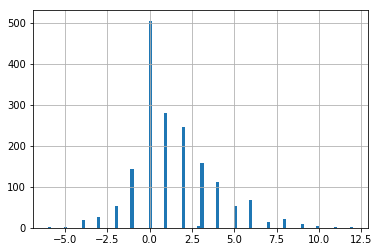

In [22]:
(6*target).hist(bins=100)
new_target = (6*target).copy()
reduced = (new_target<-0.5)
same = (new_target >-.5) & (new_target <.5)
increased = (new_target >.5)
new_target[reduced] = "reduced"
new_target[same] = "same"
new_target[increased] = "increased"
new_target = new_target.astype('category')

In [23]:
new_target = round(6*target).apply(lambda x: min(x,10))
new_target = new_target.astype('category')

In [24]:
new_target.shape

(1721,)

In [48]:
%%time
## try Boruta
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy

# load X and y
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
# X = pd.read_csv('examples/test_X.csv', index_col=0).values
X = BES_immigEcon.values
# y = pd.read_csv('examples/test_y.csv', header=None, index_col=0).values
# y = new_target.values
y = target.values
y = y.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=7)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, perc=99)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

BES_immigEcon.columns[ feat_selector.support_ ]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	2560
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	2560
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	2560
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	2560
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	2560
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	2560
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	2560
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	143
Rejected: 	2417


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	66
Tentative: 	77
Rejected: 	2417


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	66
Tentative: 	77
Rejected: 	2417


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	66
Tentative: 	77
Rejected: 	2417


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	66
Tentative: 	57
Rejected: 	2437


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	66
Tentative: 	57
Rejected: 	2437


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	66
Tentative: 	57
Rejected: 	2437


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	66
Tentative: 	57
Rejected: 	2437


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	66
Tentative: 	44
Rejected: 	2450


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	66
Tentative: 	44
Rejected: 	2450


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	66
Tentative: 	44
Rejected: 	2450


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	66
Tentative: 	38
Rejected: 	2456


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	66
Tentative: 	38
Rejected: 	2456


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	66
Tentative: 	38
Rejected: 	2456


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	66
Tentative: 	32
Rejected: 	2462


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	66
Tentative: 	32
Rejected: 	2462


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	66
Tentative: 	32
Rejected: 	2462


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	66
Tentative: 	32
Rejected: 	2462


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	66
Tentative: 	32
Rejected: 	2462


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	66
Tentative: 	30
Rejected: 	2464


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	66
Tentative: 	30
Rejected: 	2464


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	66
Tentative: 	30
Rejected: 	2464


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	66
Tentative: 	28
Rejected: 	2466


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	66
Tentative: 	28
Rejected: 	2466


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	66
Tentative: 	23
Rejected: 	2471


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	66
Tentative: 	23
Rejected: 	2471


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	66
Tentative: 	19
Rejected: 	2475


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	66
Tentative: 	19
Rejected: 	2475


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	66
Tentative: 	19
Rejected: 	2475


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	66
Tentative: 	19
Rejected: 	2475


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	66
Tentative: 	18
Rejected: 	2476


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	66
Tentative: 	18
Rejected: 	2476


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	66
Tentative: 	15
Rejected: 	2479


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	66
Tentative: 	15
Rejected: 	2479


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	66
Tentative: 	15
Rejected: 	2479


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	66
Tentative: 	13
Rejected: 	2481


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	66
Tentative: 	13
Rejected: 	2481


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	66
Tentative: 	13
Rejected: 	2481


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	66
Tentative: 	12
Rejected: 	2482


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	66
Tentative: 	12
Rejected: 	2482


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	66
Tentative: 	12
Rejected: 	2482


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	66
Tentative: 	12
Rejected: 	2482


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	66
Tentative: 	12
Rejected: 	2482


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	66
Tentative: 	11
Rejected: 	2483


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	66
Tentative: 	11
Rejected: 	2483


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	66
Tentative: 	11
Rejected: 	2483


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	66
Tentative: 	9
Rejected: 	2485


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	66
Tentative: 	9
Rejected: 	2485


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	66
Tentative: 	9
Rejected: 	2485


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	66
Tentative: 	9
Rejected: 	2485


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	66
Tentative: 	9
Rejected: 	2485


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	66
Tentative: 	9
Rejected: 	2485


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	66
Tentative: 	9
Rejected: 	2485


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	66
Tentative: 	9
Rejected: 	2485


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486
Iteration: 	71 / 100
Confirmed: 	66
Tentative: 	8
Rejected: 	2486


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	66
Tentative: 	7
Rejected: 	2487


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489
Iteration: 	99 / 100
Confirmed: 	66
Tentative: 	5
Rejected: 	2489


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	66
Tentative: 	1
Rejected: 	2489


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Index(['generalElectionCertaintyW5__Completely certain', 'leftRightW6__Right',
       'europeannessW7__Very strongly European',
       'trustMPsW7__A great deal of trust', 'benefitsToMigrantsW7__Never',
       'effectsEUTerrorW7__Much higher', 'leftRightW7__Right',
       'familiesMoreW7__Many more', 'immigSelfW7__Allow many more',
       'labUnitedW7__Very united', 'euRefCertaintyW8__Completely certain',
       'euRefExpectationW8__100 - UK will definitely vote to leave the EU',
       'likeConW8__Strongly like', 'likeUKIPW8__Strongly like',
       'changeCostLiveW8__Getting a lot higher',
       'EUIntegrationConW8__Protect our independence',
       'effectsEUUnemploymentW8__Much higher',
       'britainFairShareW8__Much more than its fair share',
       'euMemberJoinW8__Strongly agree',
       'socialIdentityGlobalLeaveW8__A great deal in common',
       'asylumMoreW8__Many more', 'euMoreW8__Many more',
       'noneuMoreW8__Many more', 'studentsMoreW8__Many more',
       'familiesMo

In [64]:
BES_immigEcon.columns[ feat_selector.support_ ]

Index(['generalElectionCertaintyW5__Completely certain', 'leftRightW6__Right',
       'europeannessW7__Very strongly European',
       'trustMPsW7__A great deal of trust', 'benefitsToMigrantsW7__Never',
       'effectsEUTerrorW7__Much higher', 'leftRightW7__Right',
       'familiesMoreW7__Many more', 'immigSelfW7__Allow many more',
       'labUnitedW7__Very united', 'euRefCertaintyW8__Completely certain',
       'euRefExpectationW8__100 - UK will definitely vote to leave the EU',
       'likeConW8__Strongly like', 'likeUKIPW8__Strongly like',
       'changeCostLiveW8__Getting a lot higher',
       'EUIntegrationConW8__Protect our independence',
       'effectsEUUnemploymentW8__Much higher',
       'britainFairShareW8__Much more than its fair share',
       'euMemberJoinW8__Strongly agree',
       'socialIdentityGlobalLeaveW8__A great deal in common',
       'asylumMoreW8__Many more', 'euMoreW8__Many more',
       'noneuMoreW8__Many more', 'studentsMoreW8__Many more',
       'familiesMo

In [229]:
# %%time
# import statsmodels.api as sm
# X = BES_immigEcon[BES_immigEcon.columns[ feat_selector.support_ ]].copy()
# clean_feature_set_std = StandardScaler().fit_transform(X.values )
# X = pd.DataFrame(clean_feature_set_std,
#                  columns = X.columns,
#                  index   = X.index      )

# X = sm.add_constant(X)
# # y = (target-target.mean())/target.std()
# y = new_target.cat.codes
# model = sm.OLS(y, X)
# results = model.fit()
# print(results.summary())


In [226]:
# results = model.fit_regularized(alpha=0.03,L1_wt=.3, profile_scale=False)
# pd.DataFrame( [X.columns, results.params] ).T.sort_values(by=1).replace(0,np.nan).dropna()

In [150]:
# https://github.com/chasedehan/BoostARoota


### try boostaroota
from boostaroota import BoostARoota

In [222]:
%%time

xgb1 = XGBRegressor(
 learning_rate =0.04, #0.04
 n_estimators= 50,   #180,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 seed=27)
#OHE the variables - BoostARoota may break if not done
# x = pd.getdummies(x)
#Specify the evaluation metric: can use whichever you like as long as recognized by XGBoost
  #EXCEPTION: multi-class currently only supports "mlogloss" so much be passed in as eval_metric
br = BoostARoota(clf=xgb1)

#Fit the model for the subset of variables
br.fit(BES_immigEcon, rounded_targets)

#Can look at the important variables - will return a pandas series
br.keep_vars_

#Then modify dataframe to only include the important variables
# br.transform(X)

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\boostaroota\boostaroota.py:39: UserWarning: You entered values for metric and clf, defaulting to clf and ignoring metric
  warnings.warn('You entered values for metric and clf, defaulting to clf and ignoring metric')


Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
Round:  3  iteration:  1
Round:  3  iteration:  2
Round:  3  iteration:  3
Round:  3  iteration:  4
Round:  3  iteration:  5
Round:  3  iteration:  6
Round:  3  iteration:  7
Round:  3  iteration:  8
Round:  3  iteration:  9
Round:  3  iteration:  10
Round:  4  iteration:  1
Round:  4  iteration:  2
Round:  4  iteration:  3
Round:  4  iteration:  4
Round:  4  iteration:  5
Round:  4  iteration:  6
Round:  4  iteration:  7
Round:  4  iteration:  8
Round:  4  iteration:  9
Round:  4  iteration: 

NameError: name 'x' is not defined

In [224]:
# br.transform(BES_immigEcon).columns

In [230]:
br.keep_vars_.to_csv(BES_small_data_files+"boostaroota_immig_important_features.csv")

10

In [ ]:
## clean this data up a bit

# add some variables to imvar_list
## europeanness, trustMPs, overseasAid, satDemUK, satDemEU, satDemEng, happyEULeave, beliefTradeoff
# effectsEUEcon, effectsEUFinance, effectsEUImmigration, effectsEUNHS,
# effectsEUTerror, effectsEUTrade, effectsEUUnemployment, effectsEUWorkers 


In [9]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "ukCoopMovement", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore",
             "europeanness", "trustMPs", "overseasAid", "beliefTradeoff",
             "satDemUK", "satDemEU", "satDemEng", "happyEULeave",
             "effectsEUEcon", "effectsEUFinance", "effectsEUImmigration", "effectsEUNHS",
             "effectsEUTerror", "effectsEUTrade", "effectsEUUnemployment", "effectsEUWorkers",
             "prefTradeoff","beliefTradeoff",
             "euRefDoOver","expectAccess","handleEUNegotiate"
             ]


# "effectsEUImmigration"

In [10]:
# im_var = "immigCultural"

num = 0
for im_var in imvar_list:
    immig, mask = get_base(im_var,noNans = False)
    immig.columns = ["Delta_"+x for x in immig.columns]
    if num ==0:
        immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
    else:
        immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1


In [11]:
# drop everything after W10
immigDiff = immigDiff.drop([x for x in immigDiff.columns if ("W11" in x)|("W12" in x)|("W13" in x)],axis=1)

In [12]:
# add both together
im_var = "immigEcon"
immig_econ,mask = get_base(im_var,waves=["W8"],noNans = False)
mask = (immig_econ < immig_econ.median())[im_var+"W8"]
mask = (mask & immigDiff["Delta_immigEconW10"].notnull()& immigDiff["Delta_immigCulturalW10"].notnull())
# mask = (mask & immigDiff["Delta_immigSelfW10"].notnull() & immigDiff["Delta_controlImmigW9"].notnull())

# BES_immigEcon = pd.concat( [ BES_reduced_with_na[mask],
#                              immigDiff[[x for x in immigDiff.columns if "W10" in x]][mask] ], axis=1)
BES_immigEcon = pd.concat( [ BES_reduced_with_na[mask],
                             immigDiff[mask] ], axis=1)
# BES_immigEcon = BES_immigEcon.drop(["Delta_changeImmigLabW10"],axis=1, errors='ignore')
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if "immigEcon" in x], axis=1)
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if "immigCultural" in x], axis=1)
# BES_immigEcon["Delta_controlImmigW9"] = immigDiff["Delta_controlImmigW9"][mask]
# BES_immigEcon = BES_immigEcon[var_list]


target = immigDiff["Delta_immigEconW10"][mask] + immigDiff["Delta_immigCulturalW10"][mask]
rounded_targets = round(target*6).apply(lambda x: min(x,10)).apply(lambda x: max(x,-4))
rounded_targets = rounded_targets.astype('float')
rounded_targets.value_counts()

 0.0     2385
 1.0     1204
 2.0     1170
 3.0      766
-1.0      571
 4.0      508
 6.0      301
-2.0      291
 5.0      254
-3.0      110
-4.0       74
 7.0       68
 8.0       62
 10.0      52
 9.0       35
dtype: int64

In [13]:
BES_immigEcon = BES_immigEcon.drop([x for x in BES_immigEcon.columns if ("W11" in x)|("W12" in x)|("W13" in x)], axis=1)

In [14]:
BES_immigEcon = BES_immigEcon.drop(BES_immigEcon.columns[BES_immigEcon.var()==0], axis=1)

In [15]:
nan_mask = BES_immigEcon.isnull()
X = BES_immigEcon.fillna(BES_immigEcon.mean())


clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X[nan_mask] = np.nan

In [16]:
# sample_weights = BES_Panel[weight_var][mask]
# print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
# sample_weights = sample_weights.fillna(sample_weights.median())

In [17]:
# BES_Panel[[x for x in BES_Panel.columns if "wt_" in x]][mask].notnull().sum().sort_values()
X["wt_new_W10"] = BES_Panel["wt_new_W10"][mask]

In [55]:
# # split data into X and y
# X = BES_immigEcon.values
# Y = rounded_targets.values
# rounded_targets.isnull().sum()

In [70]:
# del xgboost
xgb_dir = "C:\\Users\\Marios\\AppData\\Local\\conda\\conda\\envs\\BES_analysis\\Lib\\site-packages\\xgboost"
import sys, os
sys.path.append(xgb_dir)
from xgboost import XGBClassifier, XGBRegressor, DMatrix, cv, plot_tree
import xgboost as xgb

In [71]:
# First XGBoost model for Pima Indians dataset
import graphviz
from numpy import loadtxt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [31]:
# `booster=”gblinear”`, `objective=”reg:linear”

In [32]:

# train_test_split(BES_immigEcon, rounded_targets, test_size=test_size, random_state=seed, stratify=Y)
import xgboost
from sklearn.model_selection import StratifiedKFold, cross_val_score,train_test_split


In [99]:
%%time
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(BES_immigEcon, rounded_targets, test_size=test_size,
                                                    random_state=seed, stratify=rounded_targets)
# fit model on training data

# alg = XGBRegressor(max_depth=3, learning_rate=0.04, n_estimators=500, silent=False,
#                    objective='reg:linear', booster='gbtree', n_jobs=1,
#                    gamma=0.0, min_child_weight=5, max_delta_step=0, subsample=1.0,
#                    colsample_bytree=1.0, colsample_bylevel=1, reg_alpha=0, reg_lambda=1.0,
#                    scale_pos_weight=1, base_score=0.5, random_state=0,
#                    )

alg = XGBRegressor(
 learning_rate =0.04, #0.04
 n_estimators= 500,   #180,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 seed=27)

# booster='gblinear': 2.59s Acc 17.61 
# booster='gbtree': 7.86s Acc 18.49 
# learning rate =0.04 -> better 19%
# max_depth = 5: Accuracy: 22.01%, Wall time: 12.7 s
# gamma=0 = .2: Accuracy: 22.01%, Wall time: 12.8 s NO EFFECt
# subsample=.8, colsample_bytree=.8: Accuracy: 20.25%, Wall time: 11.1 s
# subsample=.9, colsample_bytree=.9: Accuracy: 20.25%, Wall time: 12.3 s
# subsample=.9, colsample_bytree=1.0: Accuracy: 20.07%, Wall time: 13 s
# subsample=.5, colsample_bytree=0.5: Accuracy: 19.72%, Wall time: 8.33 s
# n_estimators=1000: Accuracy: 21.65%, Wall time: 2min 3s
# reg_alpha=1e-5: Accuracy: 22.01%, Wall time: 12.5 s
# reg_alpha=100: Accuracy: 18.13%, Wall time: 12.6 s
# reg_alpha=.1: Accuracy: 20.95%, Wall time: 12.5 s
# reg_lambda=0: Accuracy: 19.19%, Wall time: 12.3 s
# reg_lambda=.01: Accuracy: 20.25%, Wall time: 12.9 s
# reg_lambda=100: Accuracy: 21.13%, Wall time: 12.4 s
# MSE: 4.51, MAE: 1.55, EV: 0.16, R2: 0.16
# MSE: 4.44, MAE: 1.58, EV: 0.17, R2: 0.17
# reg_alpha=.5; MSE: 4.43, MAE: 1.57, EV: 0.17, R2: 0.17
# reg_alpha=100; MSE: 4.43, MAE: 1.57, EV: 0.17, R2: 0.17
# reg_alpha=100, reg_lambda=0.5; MSE: 4.43, MAE: 1.57, EV: 0.17, R2: 0.17
# MSE: 4.41, MAE: 1.57, EV: 0.18, R2: 0.18

eval_set = [(X_test, y_test)]
alg.fit(X_train, y_train)
        #, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = alg.predict(X_test)
# predictions = [round(value) for value in y_pred]
predictions = y_pred
# evaluate predictions
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
EV = explained_variance_score(y_test, predictions)
R2 = r2_score(y_test, predictions)

print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )



MSE: 4.41, MAE: 1.57, EV: 0.18, R2: 0.18
Wall time: 2min 32s


In [202]:
# %%time


Y = rounded_targets
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7, stratify=Y)
# fit model no training data
model = XGBRegressor(
 learning_rate =0.04, 
 n_estimators= 500, 
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 seed=27)

eval_metric_list = ["rmse", "mae", "logloss"]

sample_weight = X_train["wt_new_W10"].values
sample_weight_eval_set = X_test["wt_new_W10"].values
X_train.drop("wt_new_W10",axis=1, inplace=True)
X_test.drop("wt_new_W10",axis=1, inplace=True)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=eval_metric_list, early_stopping_rounds = 25,
          eval_set=eval_set, verbose=True,
          sample_weight = sample_weight)
          #, sample_weight_eval_set = [sample_weight_eval_set])
# make predictions for test data

predictions = model.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
EV = explained_variance_score(y_test, predictions)
R2 = r2_score(y_test, predictions)

print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


[0]	validation_0-rmse:2.45757	validation_0-mae:1.77557	validation_0-logloss:0.465425	validation_1-rmse:2.46123	validation_1-mae:1.77668	validation_1-logloss:0.483716
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 25 rounds.
[1]	validation_0-rmse:2.43706	validation_0-mae:1.76359	validation_0-logloss:0.245316	validation_1-rmse:2.44219	validation_1-mae:1.76537	validation_1-logloss:0.283994
[2]	validation_0-rmse:2.4177	validation_0-mae:1.75129	validation_0-logloss:-0.40202	validation_1-rmse:2.42499	validation_1-mae:1.75416	validation_1-logloss:0.079459
[3]	validation_0-rmse:2.39824	validation_0-mae:1.73845	validation_0-logloss:-1.27515	validation_1-rmse:2.40664	validation_1-mae:1.74176	validation_1-logloss:-0.526656
[4]	validation_0-rmse:2.37953	validation_0-mae:1.72673	validation_0-logloss:-3.25083	validation_1-rmse:2.38971	validation_1-mae:1.73066	validation_1-logloss:-1.9579
[5]	va

[49]	validation_0-rmse:2.07648	validation_0-mae:1.56444	validation_0-logloss:-21.4914	validation_1-rmse:2.15834	validation_1-mae:1.60703	validation_1-logloss:-19.5762
[50]	validation_0-rmse:2.07393	validation_0-mae:1.56311	validation_0-logloss:-21.5149	validation_1-rmse:2.15684	validation_1-mae:1.60644	validation_1-logloss:-19.5528
[51]	validation_0-rmse:2.07074	validation_0-mae:1.56151	validation_0-logloss:-21.5231	validation_1-rmse:2.155	validation_1-mae:1.60581	validation_1-logloss:-19.6084
[52]	validation_0-rmse:2.06864	validation_0-mae:1.5604	validation_0-logloss:-21.596	validation_1-rmse:2.15456	validation_1-mae:1.60605	validation_1-logloss:-19.4745
[53]	validation_0-rmse:2.06603	validation_0-mae:1.55893	validation_0-logloss:-21.5241	validation_1-rmse:2.15357	validation_1-mae:1.60576	validation_1-logloss:-19.3744
[54]	validation_0-rmse:2.06362	validation_0-mae:1.55748	validation_0-logloss:-21.7423	validation_1-rmse:2.15243	validation_1-mae:1.60518	validation_1-logloss:-19.3585
[5

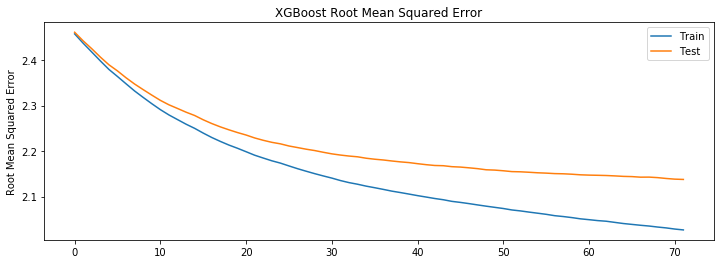

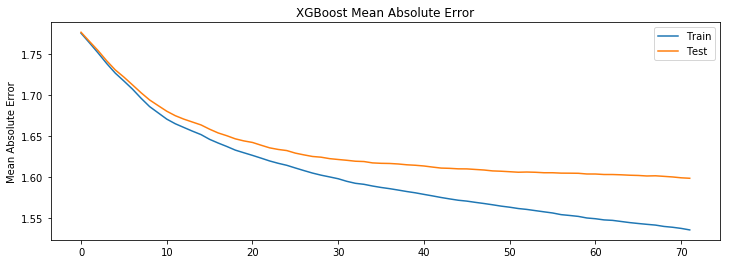

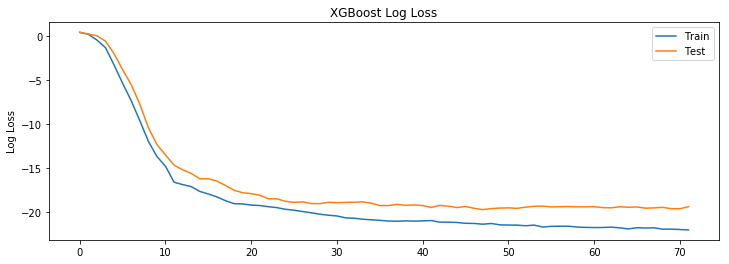

In [203]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0'][eval_metric_list[0]])
x_axis = range(0, epochs)
# plot Root Mean Squared Error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["rmse"], label='Train')
ax.plot(x_axis, results['validation_1']["rmse"], label='Test')
ax.legend()
plt.ylabel("Root Mean Squared Error")
plt.title('XGBoost Root Mean Squared Error')
plt.show()

# plot Mean Absolute Error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["mae"], label='Train')
ax.plot(x_axis, results['validation_1']["mae"], label='Test')
ax.legend()
plt.ylabel('Mean Absolute Error')
plt.title('XGBoost Mean Absolute Error')
plt.show()

# plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [204]:
%%time
model.set_params(n_estimators=50) # avoid overfitting!
sample_weight = X["wt_new_W10"].values
X.drop("wt_new_W10",axis=1,inplace=True)

model.fit(X, Y, verbose=True,
          sample_weight = sample_weight)

Wall time: 19.9 s


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


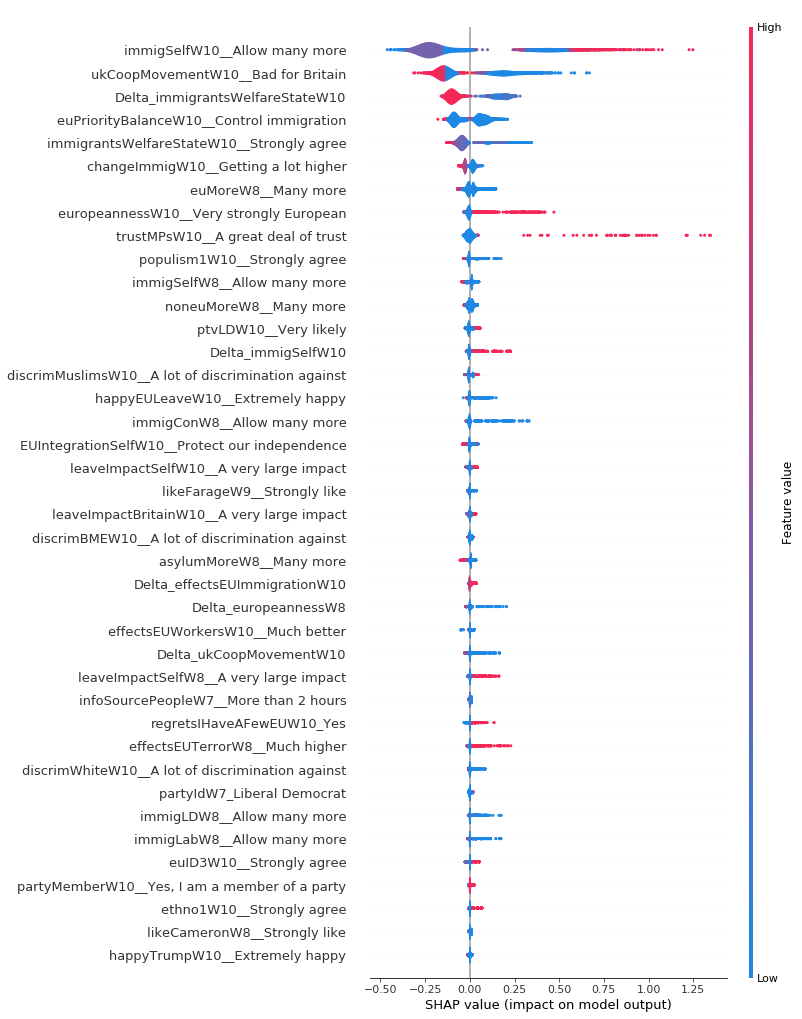

In [209]:
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X, max_display=40, plot_type='violin')

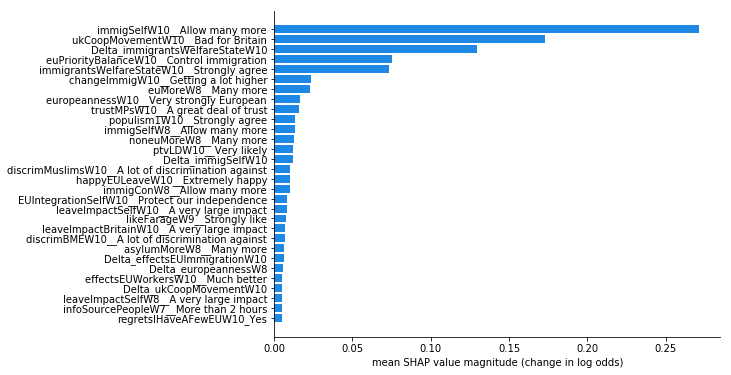

In [220]:
items = 30
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
inds = np.argsort(global_shap_vals)[-items:]
# y_pos = np.arange(9)
y_pos = np.arange(items)
# plt.figure(figsize=(12,10))
plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
plt.yticks(y_pos, X.columns[inds])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(8, 6)
plt.show()

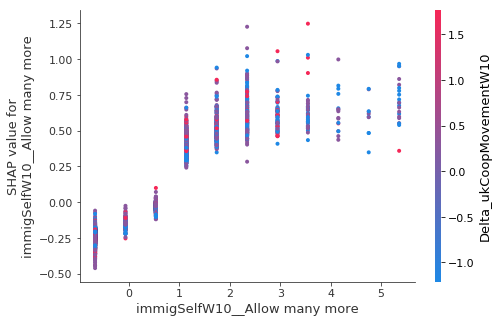

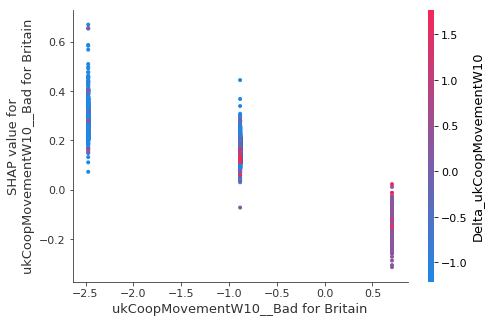

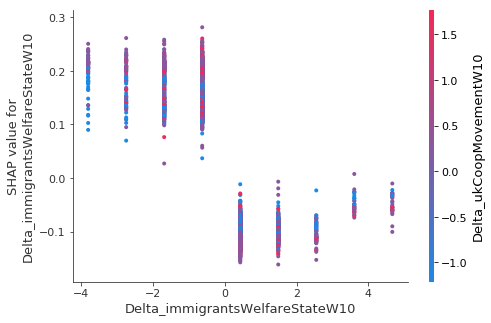

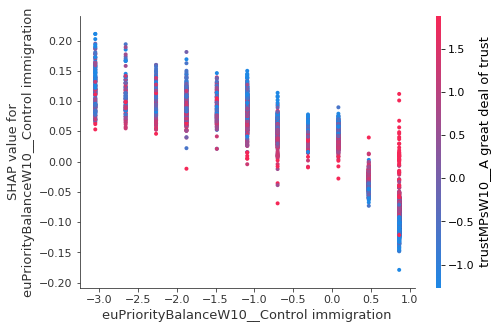

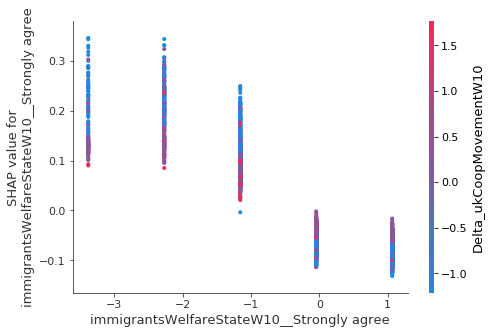

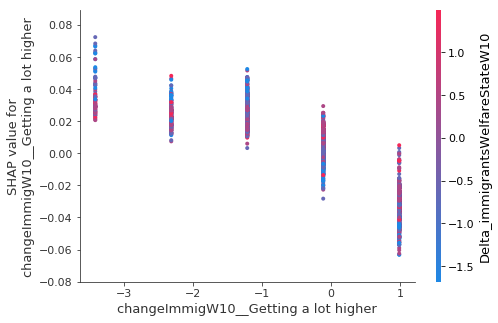

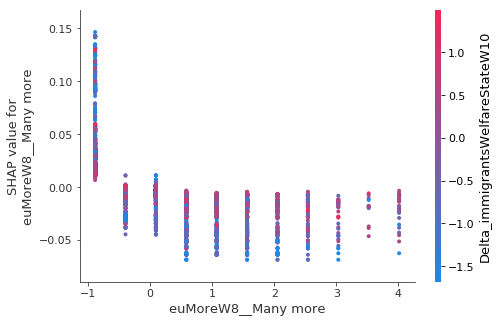

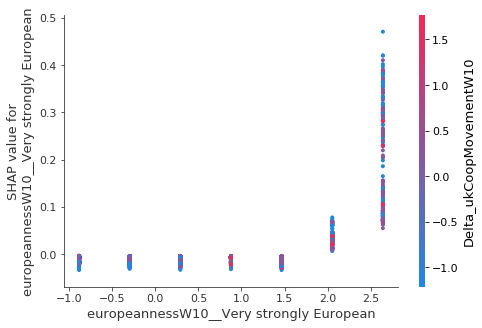

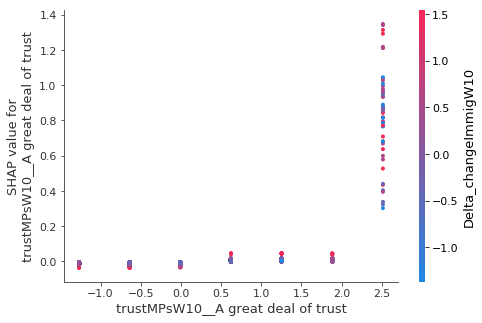

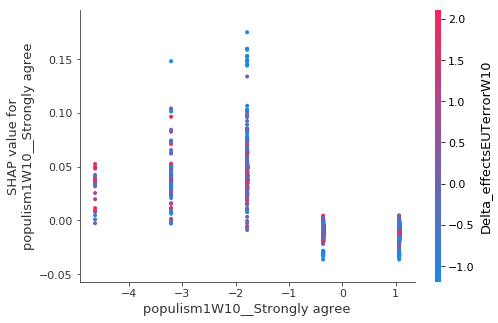

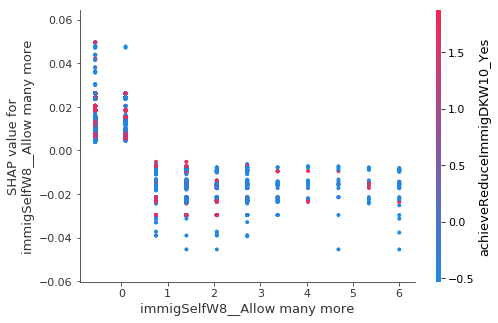

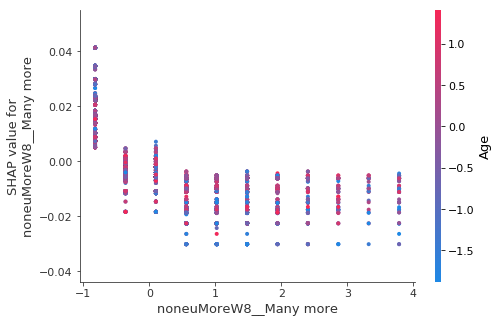

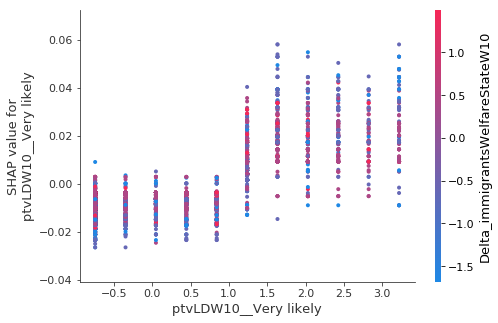

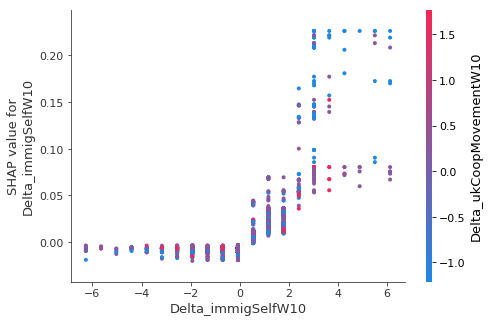

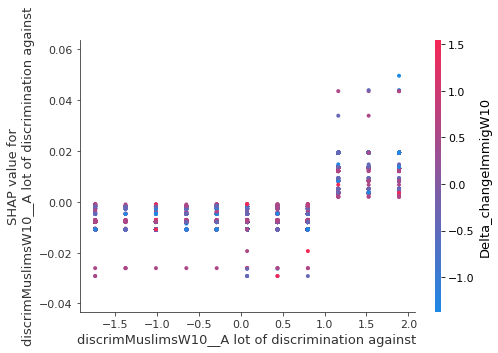

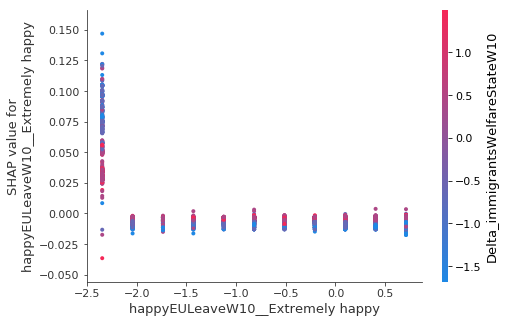

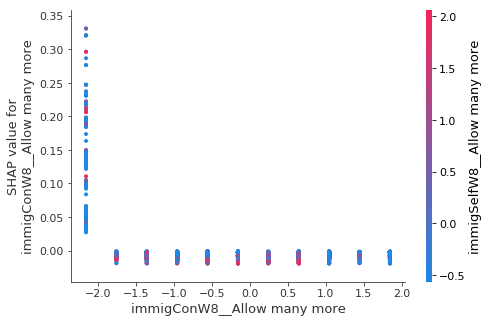

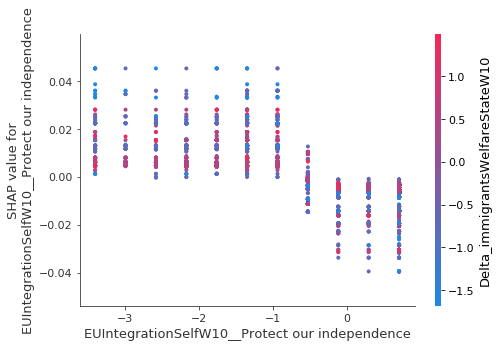

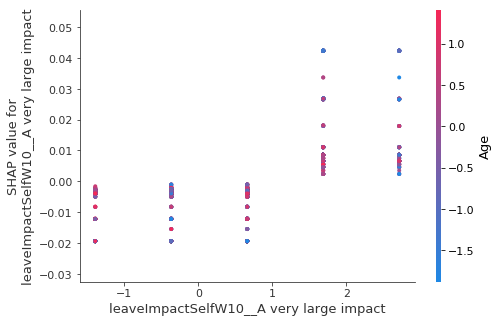

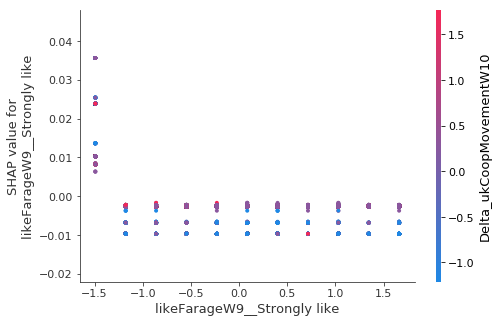

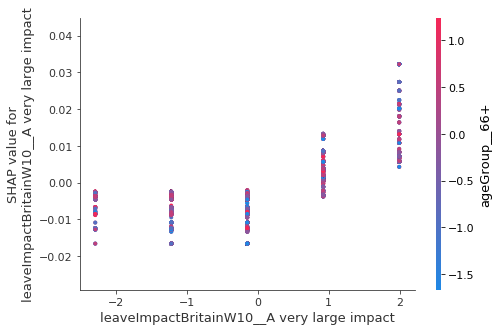

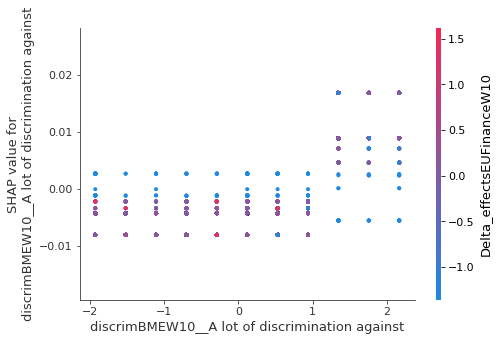

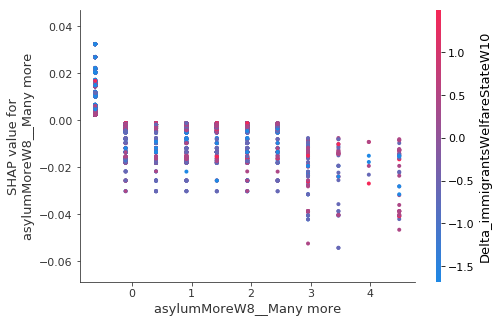

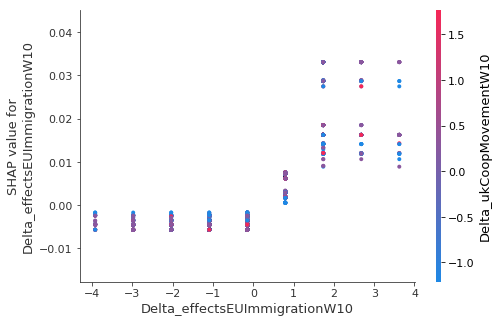

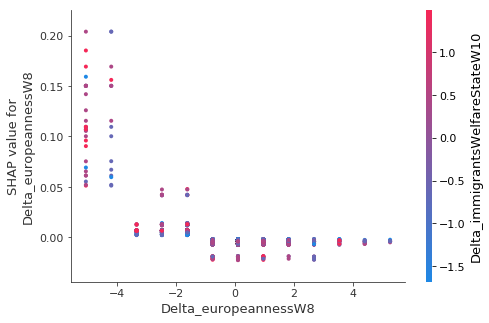

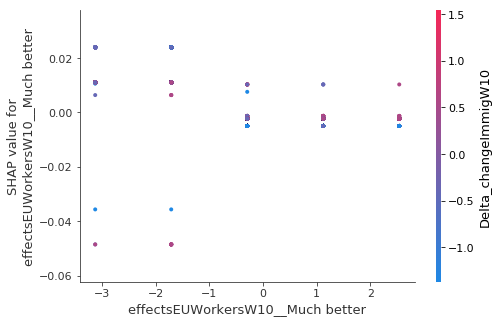

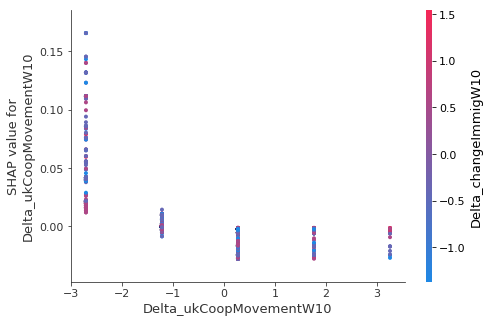

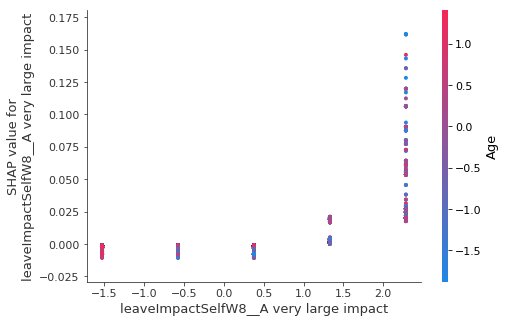

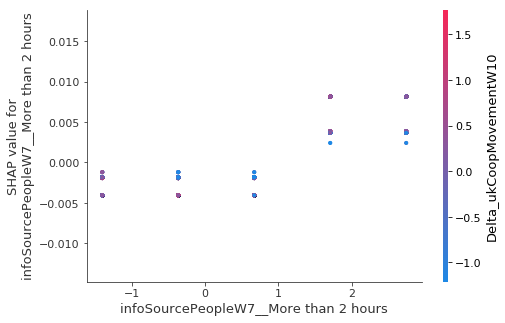

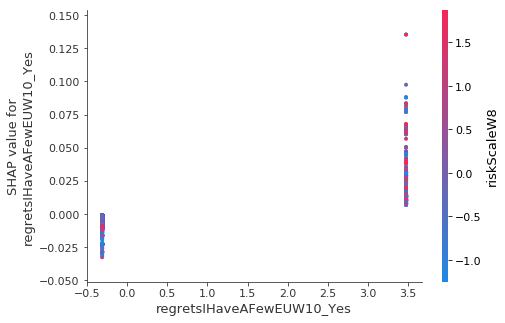

In [221]:
for name in X.columns[inds[::-1]]:
    shap.dependence_plot(name, shap_values, X)

In [212]:
shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:-1])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:-1])
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

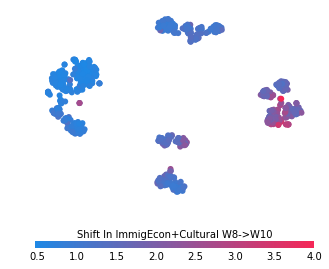

In [213]:
f = plt.figure(figsize=(5,5))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = plt.colorbar(label="Shift In ImmigEcon+Cultural W8->W10", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")
plt.show()

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


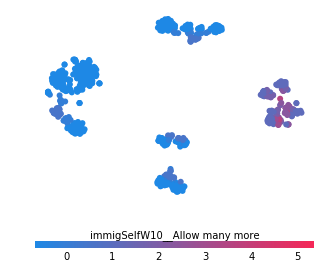

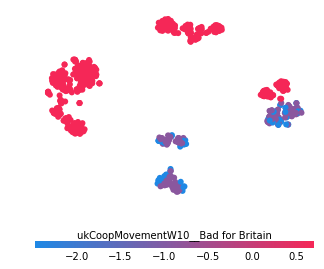

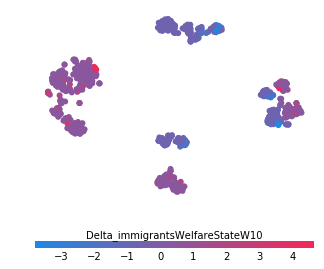

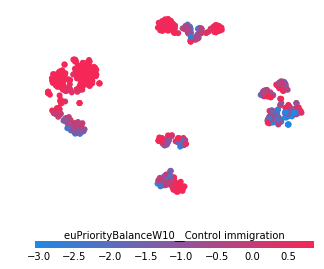

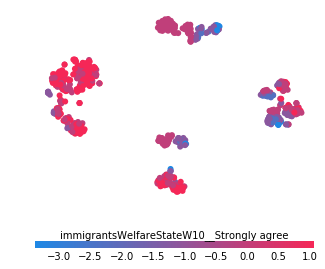

In [214]:
for feature in X.columns[inds[::-1]][0:5]:
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].as_matrix()[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = plt.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    plt.gca().axis("off")
    plt.show()

In [25]:
%%time


model = XGBRegressor(
 learning_rate =0.04, #0.04
 n_estimators= 500,   #180,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 seed=27)

# train XGBoost model
# X,y = shap.datasets.boston()
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)
model.fit(BES_immigEcon, rounded_targets)

Wall time: 3min 9s


In [51]:
model=alg

In [57]:
%%time
import shap
shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
shap_values = shap.TreeExplainer(model).shap_values(BES_immigEcon)

In [107]:
# visualize the first prediction's explanation
shap.force_plot(shap_values[0,:], BES_immigEcon.iloc[0,:])

In [33]:
?shap.summary_plot

In [125]:
# visualize the training set predictions
subsample = np.random.rand(BES_immigEcon.shape[0])<(10/100)
# shap.force_plot(shap_values[subsample], BES_immigEcon[subsample])

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


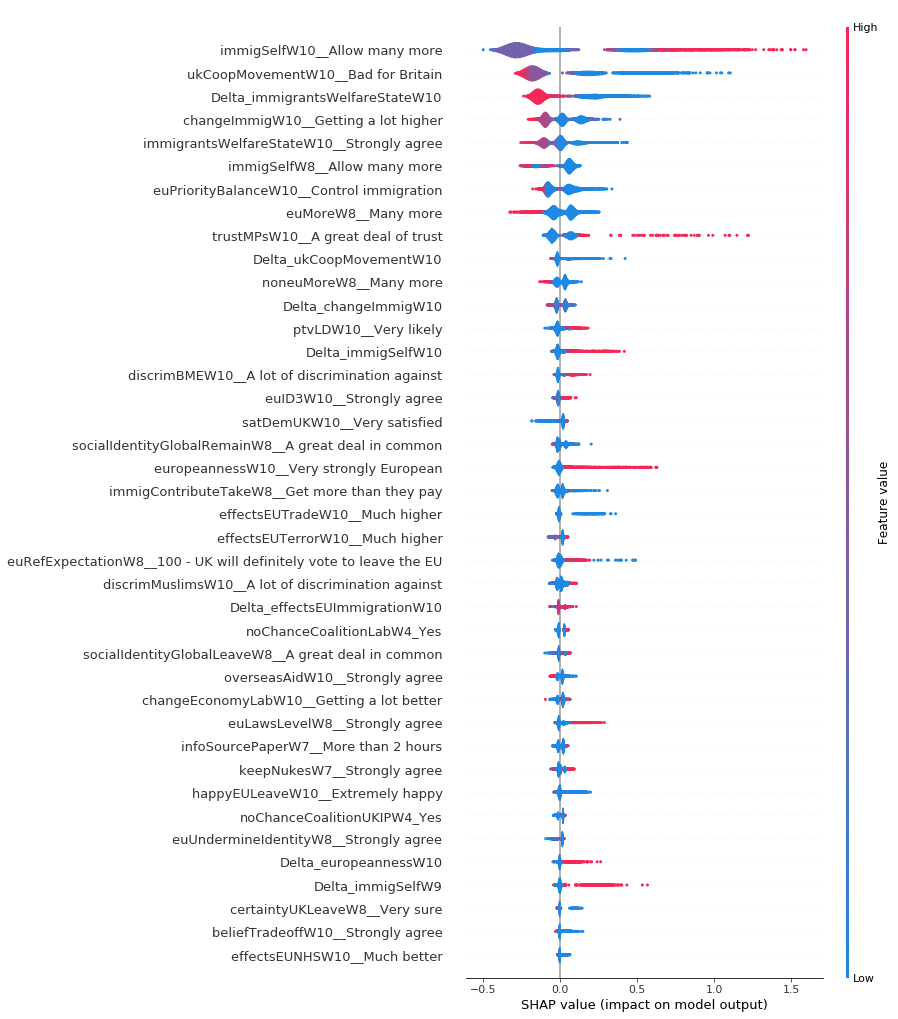

In [84]:
# BES_immigEcon.loc[:,subsample]
# max_display
shap.summary_plot(shap_values, BES_immigEcon, max_display=40, plot_type='violin')


In [61]:
# summarize the effects of all the features
# shap.summary_plot(shap_values, BES_immigEcon)

In [82]:
[x for x in BES_reduced.columns if "immigContribute" in x]

['immigContributeTakeW7__Get more than they pay',
 'immigContributeTakeW8__Get more than they pay']

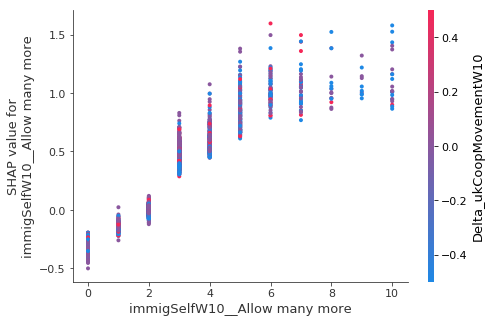

In [63]:
shap.dependence_plot("immigSelfW10__Allow many more", shap_values, BES_immigEcon)

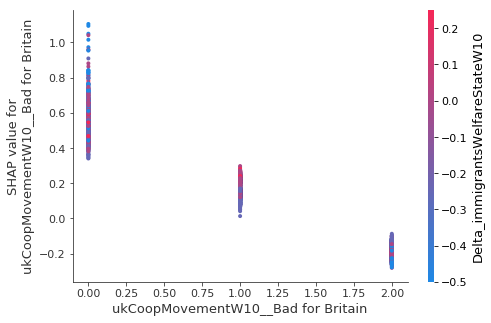

In [64]:
shap.dependence_plot("ukCoopMovementW10__Bad for Britain", shap_values, BES_immigEcon)

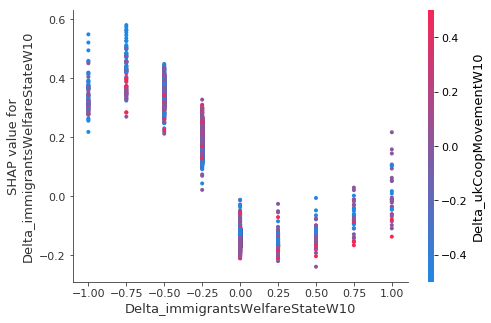

In [65]:
shap.dependence_plot("Delta_immigrantsWelfareStateW10", shap_values, BES_immigEcon)

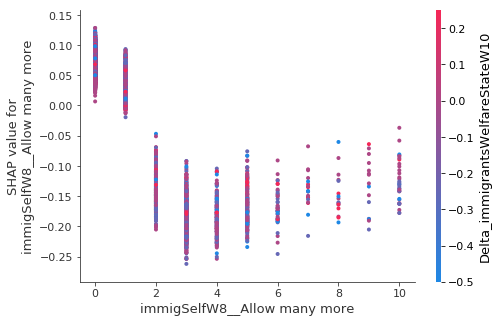

In [66]:
shap.dependence_plot("immigSelfW8__Allow many more", shap_values, BES_immigEcon)

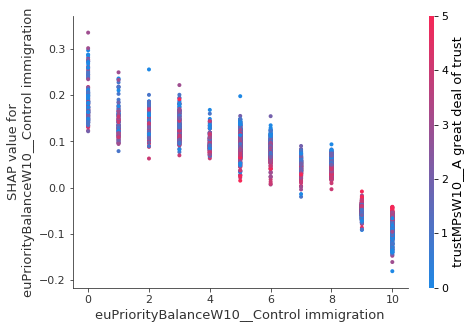

In [67]:
shap.dependence_plot("euPriorityBalanceW10__Control immigration", shap_values, BES_immigEcon)

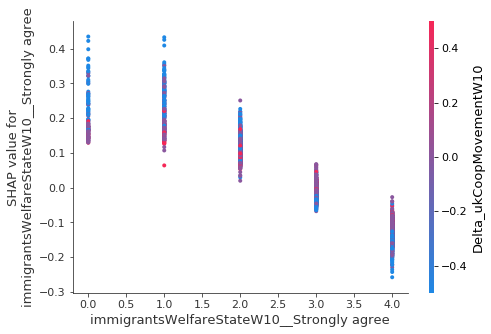

In [68]:
shap.dependence_plot("immigrantsWelfareStateW10__Strongly agree", shap_values, BES_immigEcon)

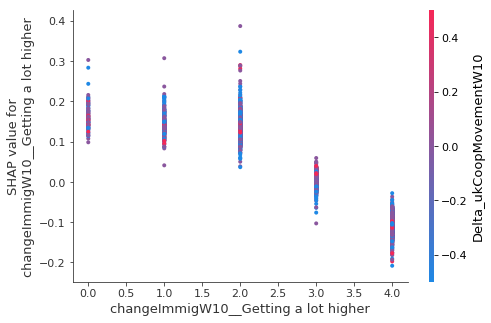

In [69]:
shap.dependence_plot("changeImmigW10__Getting a lot higher", shap_values, BES_immigEcon)

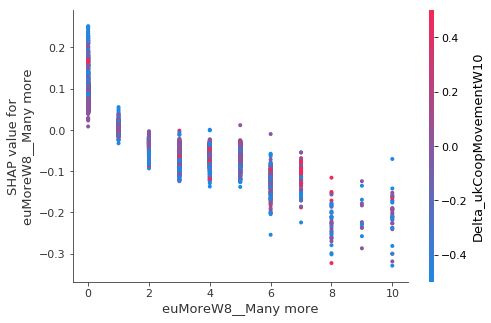

In [70]:
shap.dependence_plot("euMoreW8__Many more", shap_values, BES_immigEcon)

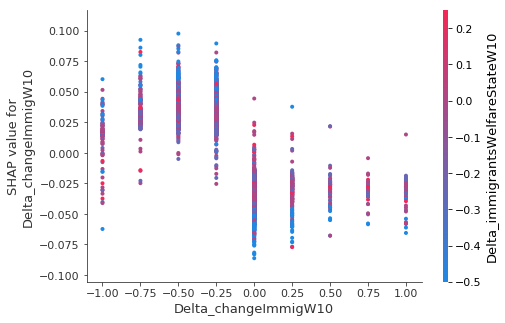

In [71]:
shap.dependence_plot("Delta_changeImmigW10", shap_values, BES_immigEcon)

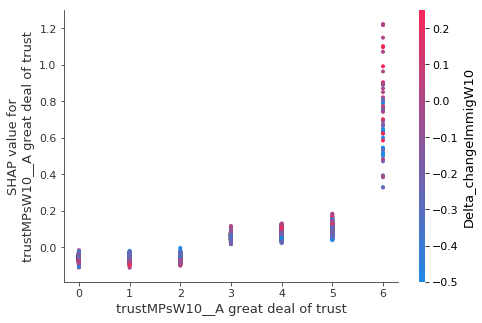

In [72]:
shap.dependence_plot("trustMPsW10__A great deal of trust", shap_values, BES_immigEcon)

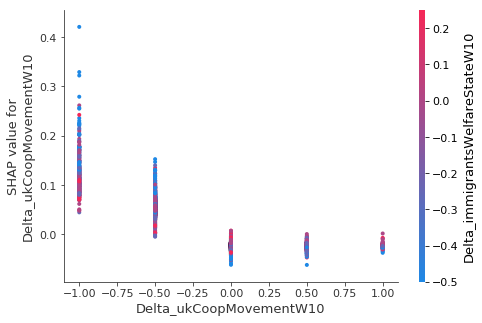

In [73]:
shap.dependence_plot("Delta_ukCoopMovementW10", shap_values, BES_immigEcon)

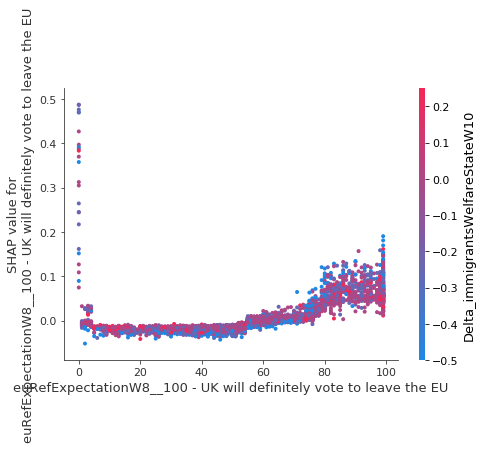

In [74]:
shap.dependence_plot("euRefExpectationW8__100 - UK will definitely vote to leave the EU", shap_values, BES_immigEcon)

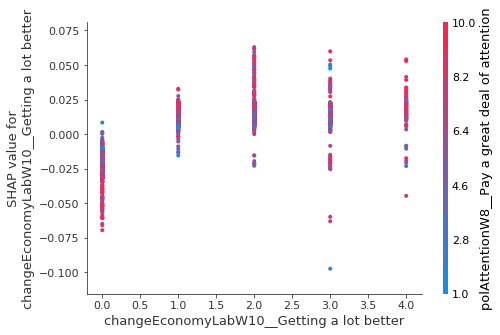

In [75]:
shap.dependence_plot('changeEconomyLabW10__Getting a lot better', shap_values, BES_immigEcon)

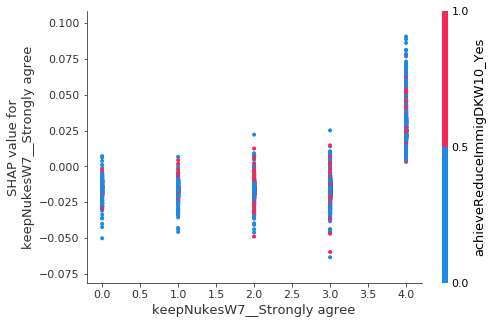

In [76]:
shap.dependence_plot('keepNukesW7__Strongly agree', shap_values, BES_immigEcon)

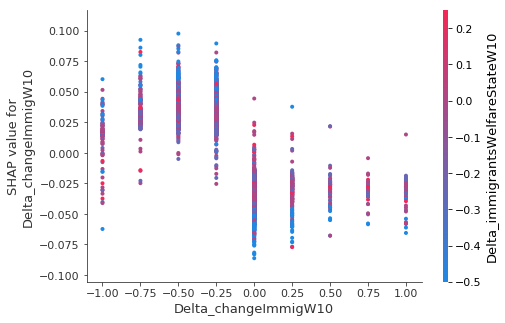

In [78]:
shap.dependence_plot('Delta_changeImmigW10', shap_values, BES_immigEcon)

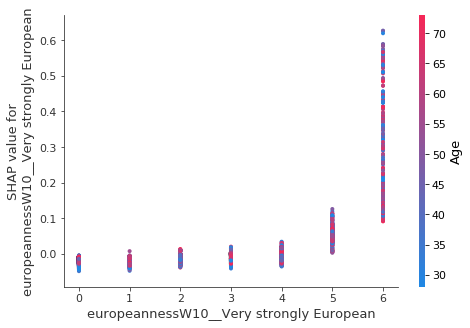

In [80]:
# 'europeannessW10__Very strongly European'
shap.dependence_plot('europeannessW10__Very strongly European', shap_values, BES_immigEcon)

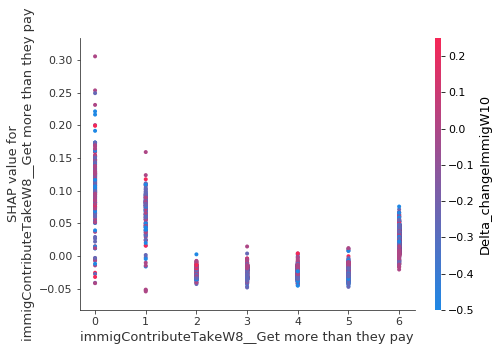

In [83]:
# 'europeannessW10__Very strongly European'
shap.dependence_plot('immigContributeTakeW8__Get more than they pay', shap_values, BES_immigEcon)

In [ ]:
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(BES_immigEcon.iloc[:200,:])
# crashes - looks like memory error!

In [33]:
gc.collect()

381

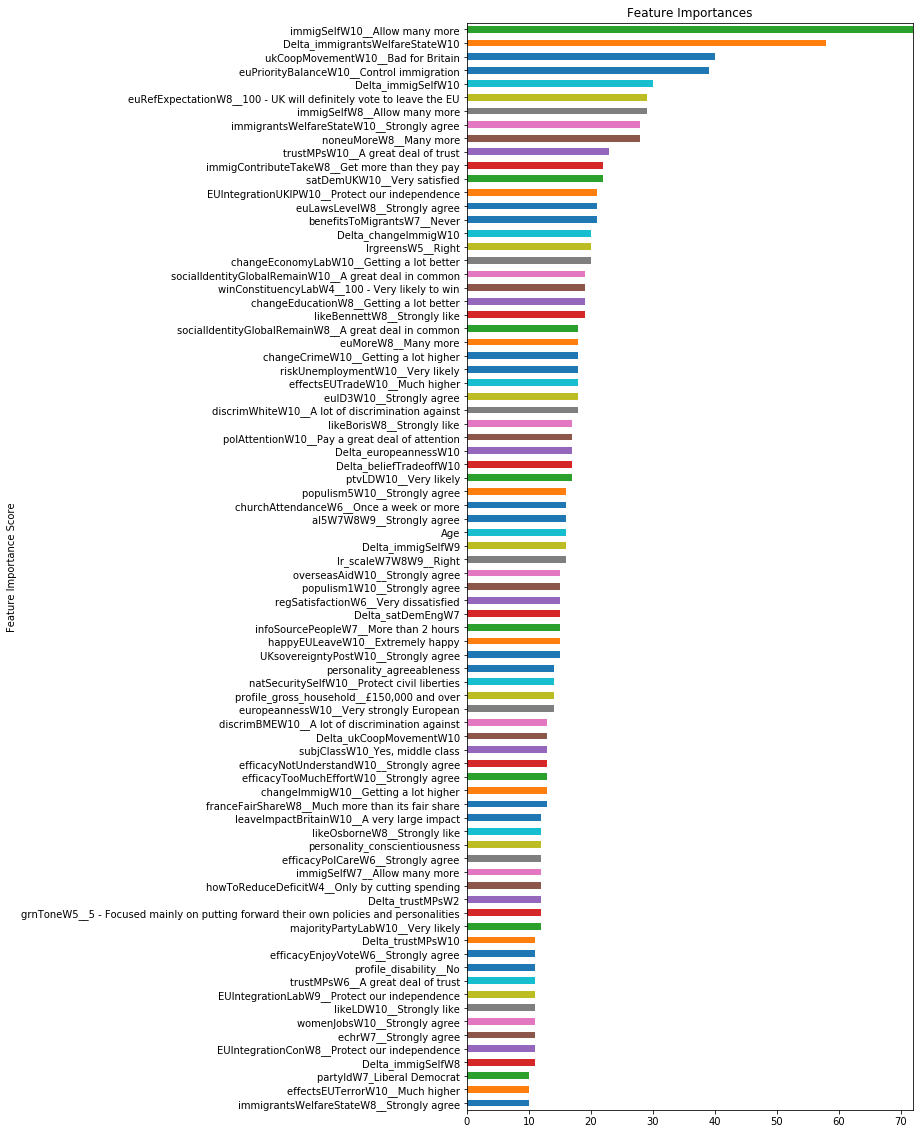

In [59]:
# comp["components_"].tail(30).plot( kind='barh', ax=comp_ax, figsize=(10,6), xlim=xlim )
num_features_to_view = 80
feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[0:num_features_to_view][::-1]
plt.figure(figsize=(8,num_features_to_view/4))
xlim = [0 , feat_imp.max() ]
feat_imp.plot(kind='barh', title='Feature Importances', xlim=xlim)
plt.ylabel('Feature Importance Score');



In [61]:
[x for x in feat_imp.index if "Delta" in x]

['Delta_immigSelfW8',
 'Delta_trustMPsW10',
 'Delta_trustMPsW2',
 'Delta_ukCoopMovementW10',
 'Delta_satDemEngW7',
 'Delta_immigSelfW9',
 'Delta_beliefTradeoffW10',
 'Delta_europeannessW10',
 'Delta_changeImmigW10',
 'Delta_immigSelfW10',
 'Delta_immigrantsWelfareStateW10']

In [34]:
import xgboost as xgb
# xgboost.cv()
# xgboost.DMatrix()

In [ ]:
# parameter tuning!

# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [35]:
from matplotlib.pylab import rcParams
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import xgboost as xgb
rcParams['figure.figsize'] = 12, 4



C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [41]:
def modelfit(alg, dtrain, predictors, target, metric, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
#         return xgtrain
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=metric, early_stopping_rounds=early_stopping_rounds, show_stdv=True, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=metric)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    return alg, dtrain_predictions

def modeldisplay(alg, dtrain, target, dtrain_predictions):
#     plt.figure(figsize = (14,10));
    #Print model report:
    print("\nModel Report" )
    print("R^2 : %.4g" % metrics.r2_score(dtrain[target].values, dtrain_predictions ) )    
    print("Explained Variance : %.4g" % metrics.explained_variance_score(dtrain[target].values, dtrain_predictions ) )    

    # print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions) )
#     print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob) )
                    
#     feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[0:50]
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    
    num_features_to_view = 80
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[0:num_features_to_view][::-1]
    plt.figure(figsize=(8,num_features_to_view/4));
    xlim = [0 , feat_imp.max() ]
    feat_imp.plot(kind='barh', title='Feature Importances', xlim=xlim);
    plt.ylabel('Feature Importance Score');
    return feat_imp

In [386]:
# BES_immigEcon[[x for x in BES_immigEcon.columns if "control" in x]].isnull().sum()

In [42]:

train = pd.concat([BES_immigEcon,rounded_targets],axis=1)
target = 0
IDcol = 'id'

#Choose all predictors except target & IDcols
drop_list = list(train.columns[train.var()==0])
# drop_list.append(target)#.append(IDcol)
predictors = [x for x in train.columns if x not in drop_list]
# predictors.append(0)
train=train[predictors]
predictors.remove(0)

xgb1 = XGBRegressor(
 learning_rate =0.04, #0.04
 n_estimators= 500,   #180,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 seed=27)


# {'colsample_bylevel': 0.9,
#  'colsample_bytree': 0.85,
#  'learning_rate': 0.04,
#  'max_depth': 3,
#  'min_child_weight': 1,
#  'scale_pos_weight': 1.0,
#  'subsample': 0.75}

# reg_alpha, reg_lamba, gamma - no effect
# mean: 0.17620, std: 0.02092, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
# mean: 0.17783, std: 0.01919, params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.95, 'subsample': 0.75},
# 'colsample_bytree': 0.9, 'subsample': 0.8
# {'colsample_bylevel': 0.95, 'colsample_bytree': 0.95, 'subsample': 0.75}
metric = 'rmse'

[0]	train-rmse:2.45732+0.0124804	test-rmse:2.45805+0.052259
[1]	train-rmse:2.43607+0.0117164	test-rmse:2.43771+0.0516346
[2]	train-rmse:2.41568+0.0110275	test-rmse:2.41868+0.0519014
[3]	train-rmse:2.3965+0.0107718	test-rmse:2.40137+0.0516068
[4]	train-rmse:2.37876+0.0106168	test-rmse:2.38469+0.0510034
[5]	train-rmse:2.36239+0.0100935	test-rmse:2.36984+0.0505491
[6]	train-rmse:2.34633+0.00968201	test-rmse:2.35549+0.0507254
[7]	train-rmse:2.33151+0.00947925	test-rmse:2.3419+0.0499955
[8]	train-rmse:2.31734+0.00937663	test-rmse:2.32842+0.0493733
[9]	train-rmse:2.30432+0.00909193	test-rmse:2.31663+0.0485729
[10]	train-rmse:2.29196+0.00915215	test-rmse:2.30524+0.0480133
[11]	train-rmse:2.28031+0.00908093	test-rmse:2.29497+0.047481
[12]	train-rmse:2.26914+0.009189	test-rmse:2.28514+0.0469969
[13]	train-rmse:2.2586+0.00922955	test-rmse:2.276+0.0466887
[14]	train-rmse:2.24875+0.00931499	test-rmse:2.26759+0.0462188
[15]	train-rmse:2.23926+0.00885702	test-rmse:2.25925+0.0458662
[16]	train-rmse:2

[131]	train-rmse:1.94465+0.00803554	test-rmse:2.10379+0.029416
[132]	train-rmse:1.94345+0.00811331	test-rmse:2.1037+0.0293983
[133]	train-rmse:1.94227+0.00802962	test-rmse:2.10363+0.0293489
[134]	train-rmse:1.94098+0.00793413	test-rmse:2.10347+0.029446
[135]	train-rmse:1.93975+0.00788764	test-rmse:2.10332+0.029142
[136]	train-rmse:1.93853+0.00783873	test-rmse:2.10312+0.0288844
[137]	train-rmse:1.93727+0.00782636	test-rmse:2.10278+0.0288528
[138]	train-rmse:1.93595+0.00776039	test-rmse:2.10239+0.028976
[139]	train-rmse:1.93464+0.00770221	test-rmse:2.10208+0.0290724
[140]	train-rmse:1.93337+0.00763808	test-rmse:2.10189+0.0289122
[141]	train-rmse:1.93214+0.00773262	test-rmse:2.10161+0.029098
[142]	train-rmse:1.93075+0.00772614	test-rmse:2.10136+0.0289279
[143]	train-rmse:1.9295+0.00783776	test-rmse:2.10107+0.0287265
[144]	train-rmse:1.92823+0.0078155	test-rmse:2.10093+0.0284829
[145]	train-rmse:1.92702+0.00776691	test-rmse:2.10069+0.0284622
[146]	train-rmse:1.92589+0.00787284	test-rmse:2.

[260]	train-rmse:1.812+0.00822705	test-rmse:2.09329+0.0279671
[261]	train-rmse:1.81125+0.00819013	test-rmse:2.0933+0.0279503
[262]	train-rmse:1.81038+0.00798788	test-rmse:2.09348+0.0281583
[263]	train-rmse:1.80943+0.00794797	test-rmse:2.09344+0.0280349
[264]	train-rmse:1.80849+0.00790491	test-rmse:2.09342+0.0279921
[265]	train-rmse:1.80763+0.00790283	test-rmse:2.09366+0.0280493
[266]	train-rmse:1.80667+0.00794345	test-rmse:2.09361+0.027935
[267]	train-rmse:1.80569+0.00796326	test-rmse:2.09348+0.0278759
[268]	train-rmse:1.80485+0.00808419	test-rmse:2.09329+0.0278903
[269]	train-rmse:1.80405+0.00810743	test-rmse:2.09329+0.0277859
[270]	train-rmse:1.80309+0.00813407	test-rmse:2.09315+0.0279809
[271]	train-rmse:1.80226+0.00798683	test-rmse:2.09304+0.0281148
[272]	train-rmse:1.80134+0.00806556	test-rmse:2.09298+0.0280918
[273]	train-rmse:1.80053+0.00803236	test-rmse:2.0929+0.0280765
[274]	train-rmse:1.79966+0.00803781	test-rmse:2.09278+0.0279618
[275]	train-rmse:1.79875+0.00813297	test-rmse

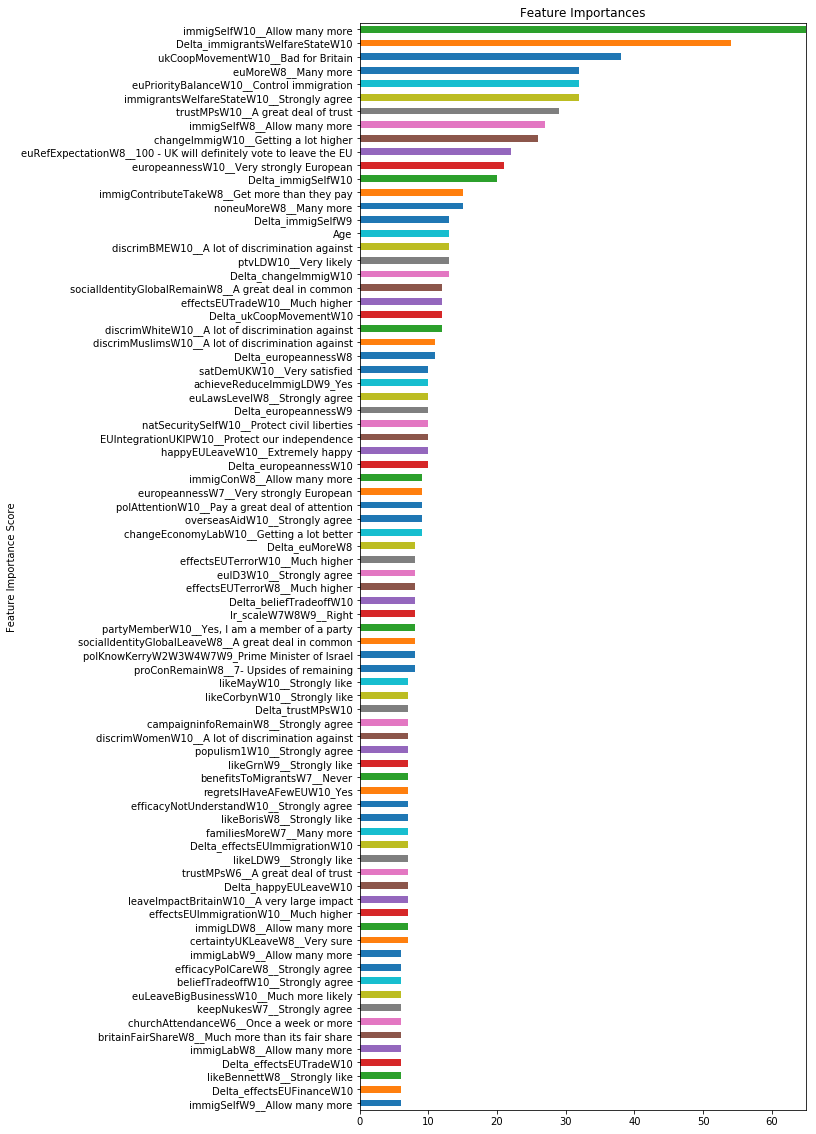

In [43]:
%%time
alg, dtrain_predictions = modelfit(xgb1, train, predictors, target, metric, useTrainCV=True)
feat_imp = modeldisplay(alg, train, target, dtrain_predictions)

 

In [48]:
sorted([x for x in BES_Panel.columns if "happyEULeave" in x])
# europeanness, trustMPs, overseasAid, satDemUK, satDemEU, satDemEng, happyEULeave, beliefTradeoff
# effectsEUEcon, effectsEUFinance, effectsEUImmigration, effectsEUNHS,
# effectsEUTerror, effectsEUTrade, effectsEUUnemployment, effectsEUWorkers 

['happyEULeaveW10', 'happyEULeaveW11', 'happyEULeaveW13', 'happyEULeaveW9']

In [19]:
%%time
param_test1 ={
     'subsample':[0.75, .8],
     'colsample_bytree':[0.9, 0.95],
     'colsample_bylevel':[0.9, 0.95]
}

gsearch1 = GridSearchCV(estimator = xgb1,
                        param_grid = param_test1,
                        scoring='r2', 
                        n_jobs=4, 
                        iid=False,
                        cv=5,
                        verbose=True)

gsearch1.fit(train[predictors],train[target])

display(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 15.2min finished


[mean: 0.17360, std: 0.02015, params: {'colsample_bylevel': 0.85, 'colsample_bytree': 0.95, 'subsample': 0.65},
 mean: 0.17246, std: 0.01931, params: {'colsample_bylevel': 0.85, 'colsample_bytree': 0.95, 'subsample': 0.75},
 mean: 0.17173, std: 0.02098, params: {'colsample_bylevel': 0.85, 'colsample_bytree': 1.0, 'subsample': 0.65},
 mean: 0.17161, std: 0.02541, params: {'colsample_bylevel': 0.85, 'colsample_bytree': 1.0, 'subsample': 0.75},
 mean: 0.17219, std: 0.02415, params: {'colsample_bylevel': 0.95, 'colsample_bytree': 0.95, 'subsample': 0.65},
 mean: 0.17592, std: 0.02032, params: {'colsample_bylevel': 0.95, 'colsample_bytree': 0.95, 'subsample': 0.75},
 mean: 0.16609, std: 0.01851, params: {'colsample_bylevel': 0.95, 'colsample_bytree': 1.0, 'subsample': 0.65},
 mean: 0.17332, std: 0.02479, params: {'colsample_bylevel': 0.95, 'colsample_bytree': 1.0, 'subsample': 0.75}]

{'colsample_bylevel': 0.95, 'colsample_bytree': 0.95, 'subsample': 0.75}

0.1759237428804699

Wall time: 16min 54s


In [85]:
model = XGBRegressor(
 learning_rate =0.04, #0.04
 n_estimators= 500,   #180,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 seed=27)

In [86]:
%%time
param_test1 ={
      'gamma':[0, 0.5],
      'reg_alpha':[0, 100],
      'reg_lambda':[1, 0.1],
      'scale_pos_weight':[1,.5],
      'max_depth':[2,4],
      'min_child_weight':[2]
    
     #'learning_rate':[0.042],
}

# mean: 0.17901, std: 0.02231, params: {'learning_rate': 0.04},

gsearch1 = GridSearchCV(estimator = model,
                        param_grid = param_test1,
                        scoring='r2', 
                        n_jobs=4, 
                        iid=False,
                        cv=5,
                        verbose=True)

gsearch1.fit(train[predictors],train[target])

display(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 21.2min
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed: 104.1min finished


[mean: 0.17598, std: 0.02185, params: {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1},
 mean: -0.70360, std: 0.05323, params: {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 0.5},
 mean: 0.17476, std: 0.02174, params: {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'scale_pos_weight': 1},
 mean: -0.72190, std: 0.07799, params: {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'scale_pos_weight': 0.5},
 mean: 0.17035, std: 0.01579, params: {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 1, 'scale_pos_weight': 1},
 mean: -0.74581, std: 0.05697, params: {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 1, 'scale_pos_weight': 0.5},
 mean: 0.17083, std: 0.01632, params: {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 0.1, 'scale_pos_weight': 1},
 mean: -0.74587, std: 0.05705, params: {'gamma': 0, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 0.1, 'scale_pos_weight': 0.5},
 mean: 0.17287, std: 0.02389, params: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1},
 mean: -0.56612, std: 0.05936, params: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 0.5},
 mean: 0.17292, std: 0.02492, params: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'scale_pos_weight': 1},
 mean: -0.58294, std: 0.07693, params: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'scale_pos_weight': 0.5},
 mean: 0.16925, std: 0.01816, params: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 1, 'scale_pos_weight': 1},
 mean: -0.69878, std: 0.07205, params: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 1, 'scale_pos_weight': 0.5},
 mean: 0.16972, std: 0.01750, params: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 0.1, 'scale_pos_weight': 1},
 mean: -0.69937, std: 0.07145, params: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 0.1, 'scale_pos_weight': 0.5},
 mean: 0.17598, std: 0.02185, params: {'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1},
 mean: -0.70310, std: 0.05340, params: {'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 0.5},
 mean: 0.17460, std: 0.02181, params: {'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'scale_pos_weight': 1},
 mean: -0.72172, std: 0.07823, params: {'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'scale_pos_weight': 0.5},
 mean: 0.17035, std: 0.01579, params: {'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 1, 'scale_pos_weight': 1},
 mean: -0.74741, std: 0.05761, params: {'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 1, 'scale_pos_weight': 0.5},
 mean: 0.17083, std: 0.01632, params: {'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 0.1, 'scale_pos_weight': 1},
 mean: -0.74696, std: 0.05793, params: {'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 100, 'reg_lambda': 0.1, 'scale_pos_weight': 0.5},
 mean: 0.17324, std: 0.02199, params: {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1},
 mean: -0.57571, std: 0.07853, params: {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 0.5},
 mean: 0.17469, std: 0.02823, params: {'gamma': 0.5, 'max_depth': 4, 'm

{'gamma': 0,
 'max_depth': 2,
 'min_child_weight': 2,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1}

0.17597891461255552

Wall time: 1h 46min 16s


In [34]:
%%time
param_test1 ={
     'gamma':[0, 0.5],
     'reg_alpha':[0, 100],
     'reg_lambda':[1, 0.1],
     'learning_rate':[0.035, 0.04, 0.45],
}

gsearch1 = GridSearchCV(estimator = model,
                        param_grid = param_test1,
                        scoring='r2', 
                        n_jobs=4, 
                        iid=False,
                        cv=5,
                        verbose=True)

gsearch1.fit(train[predictors],train[target])

display(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 74.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 167.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 315.8min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 520.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 772.3min
[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed: 951.9min finished


[mean: 0.04599, std: 0.01730, params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'scale_pos_weight': 0.9, 'subsample': 0.75},
 mean: 0.04527, std: 0.01767, params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'scale_pos_weight': 0.9, 'subsample': 0.85},
 mean: 0.12741, std: 0.01436, params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'scale_pos_weight': 1.0, 'subsample': 0.75},
 mean: 0.12630, std: 0.01429, params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'scale_pos_weight': 1.0, 'subsample': 0.85},
 mean: 0.04599, std: 0.01730, params: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'scale_pos_weight': 0.9, 'subsample': 0.75},
 mean: 0.0

{'colsample_bylevel': 0.9,
 'colsample_bytree': 0.85,
 'learning_rate': 0.04,
 'max_depth': 3,
 'min_child_weight': 1,
 'scale_pos_weight': 1.0,
 'subsample': 0.75}

0.17947346066839742

Wall time: 15h 55min


In [ ]:
# 8 candidates = 16 mins, 1 candidate /2 mins


# 14 hrs -> 14x60/2 = 30*14 = 420 candidates

In [431]:
# baseline 0.17525

[0.6, 0.7, 0.8, 0.9]

In [371]:
[x for x in feat_imp.index if "Delta" in x]

['Delta_euMoreW8',
 'Delta_effectsEUImmigrationW8',
 'Delta_ukCoopMovementW10',
 'Delta_changeImmigW10',
 'Delta_familiesMoreW13',
 'Delta_immigSelfW9',
 'Delta_asylumMoreW13',
 'Delta_immigrantsWelfareStateW10',
 'Delta_euMoreW13']

In [398]:
%%time
param_test1 ={
 'max_depth':[1,2,3],
 'min_child_weight':[1,2,4,6]
}

gsearch1 = GridSearchCV(estimator = xgb1,
                        param_grid = param_test1,
                        scoring='r2', 
                        n_jobs=4, 
                        iid=False,
                        cv=5,
                        verbose=True)

gsearch1.fit(train[predictors],train[target])

display(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 22.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 40.5min finished
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.17525, std: 0.01692, params: {'max_depth': 2, 'min_child_weight': 2},
 mean: 0.17441, std: 0.01573, params: {'max_depth': 2, 'min_child_weight': 4},
 mean: 0.17414, std: 0.01755, params: {'max_depth': 2, 'min_child_weight': 6},
 mean: 0.15732, std: 0.01859, params: {'max_depth': 4, 'min_child_weight': 2},
 mean: 0.15557, std: 0.02247, params: {'max_depth': 4, 'min_child_weight': 4},
 mean: 0.15298, std: 0.01525, params: {'max_depth': 4, 'min_child_weight': 6},
 mean: 0.13731, std: 0.01948, params: {'max_depth': 6, 'min_child_weight': 2},
 mean: 0.14189, std: 0.01656, params: {'max_depth': 6, 'min_child_weight': 4},
 mean: 0.13133, std: 0.02496, params: {'max_depth': 6, 'min_child_weight': 6},
 mean: 0.13269, std: 0.02105, params: {'max_depth': 8, 'min_child_weight': 2},
 mean: 0.13351, std: 0.01705, params: {'max_depth': 8, 'min_child_weight': 4},
 mean: 0.13549, std: 0.02149, params: {'max_depth': 8, 'min_child_weight': 6}]

{'max_depth': 2, 'min_child_weight': 2}

0.17525114143906323

Wall time: 41min 48s


In [399]:
%%time
param_test1 ={
 'max_depth':[1,3],
 'min_child_weight':[1,3]
}

gsearch1 = GridSearchCV(estimator = xgb1,
                        param_grid = param_test1,
                        scoring='r2', 
                        n_jobs=4, 
                        iid=False,
                        cv=5,
                        verbose=True)

gsearch1.fit(train[predictors],train[target])

display(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  6.2min finished
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.16458, std: 0.01652, params: {'max_depth': 1, 'min_child_weight': 1},
 mean: 0.16458, std: 0.01652, params: {'max_depth': 1, 'min_child_weight': 3},
 mean: 0.16860, std: 0.01932, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.16705, std: 0.01928, params: {'max_depth': 3, 'min_child_weight': 3}]

{'max_depth': 3, 'min_child_weight': 1}

0.16859827582590917

Wall time: 8min 5s


([mean: 0.17419, std: 0.02079, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.17341, std: 0.02122, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.17478, std: 0.01925, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.16797, std: 0.01713, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.16575, std: 0.01791, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.16323, std: 0.01610, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.15540, std: 0.01722, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.15476, std: 0.01909, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.15758, std: 0.02191, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.13626, std: 0.02166, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.13570, std: 0.01960, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.14371, std: 0.02133, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 5

In [98]:
# variables = pd.DataFrame.from_dict({key:sys.getsizeof(value) for (key,value) in locals().items()},orient='index')
# variables.sort_values(by=0,ascending=False)
    #print(var, sys.getsizeof(obj))

In [224]:
feat_imp

immigSelfW10__Allow many more                                        77
Delta_immigrantsWelfareStateW10                                      75
ukCoopMovementW10__Bad for Britain                                   60
turnoutUKGeneralW1__Very likely that I will vote                     56
trustMPsW10__A great deal of trust                                   54
euPriorityBalanceW10__Control immigration                            53
immigSelfW8__Allow many more                                         52
euMoreW8__Many more                                                  48
immigrantsWelfareStateW10__Strongly agree                            41
euRefExpectationW8__100 - UK will definitely vote to leave the EU    40
euMoreW13__Many more                                                 39
warmAsianW11__Very warm                                              36
immigSelfW11__Allow many more                                        33
changeImmigW10__Getting a lot higher                            

In [429]:
# %%time

feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[0:20]
major_predictors = list(feat_imp.index)
major_predictors.append('Delta_controlImmigW9')
major_predictors.remove('euRefExpectationW8__100 - UK will definitely vote to leave the EU')
major_predictors.remove('Delta_euMoreW13')
major_predictors.remove('immigSelfW8__Allow many more')
major_predictors.remove('immigSelfW11__Allow many more')
major_predictors.remove('Delta_asylumMoreW13')
major_predictors.remove('euMoreW8__Many more')
#

 
 

mask = BES_immigEcon[major_predictors].notnull().all(axis=1)

import statsmodels.api as sm
X = BES_immigEcon[major_predictors][mask].copy()
clean_feature_set_std = StandardScaler().fit_transform(X.values )
X = pd.DataFrame(clean_feature_set_std,
                 columns = X.columns,
                 index   = X.index      )

X = sm.add_constant(X)
# y = (target-target.mean())/target.std()
y = rounded_targets[mask]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


# ==============================================================================
# Dep. Variable:                      y   R-squared:                       0.176
# Model:                            OLS   Adj. R-squared:                  0.171
# Method:                 Least Squares   F-statistic:                     33.94
# Date:                Fri, 15 Jun 2018   Prob (F-statistic):          8.34e-118
# Time:                        17:39:52   Log-Likelihood:                -6662.4
# No. Observations:                3193   AIC:                         1.337e+04
# Df Residuals:                    3172   BIC:                         1.349e+04
# Df Model:                          20                                         
# Covariance Type:            nonrobust                                         



# R-squared:                       0.171
# Delta_controlImmigW9                                                 -0.0215      0.094     -0.229      0.819


# remove

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     12.16
Date:                Fri, 15 Jun 2018   Prob (F-statistic):           2.06e-28
Time:                        17:54:34   Log-Likelihood:                -2558.2
No. Observations:                1173   AIC:                             5148.
Df Residuals:                    1157   BIC:                             5229.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [419]:
major_predictors

['immigSelfW10__Allow many more',
 'Delta_immigrantsWelfareStateW10',
 'ukCoopMovementW10__Bad for Britain',
 'trustMPsW10__A great deal of trust',
 'immigSelfW8__Allow many more',
 'Delta_euMoreW13',
 'immigrantsWelfareStateW10__Strongly agree',
 'euMoreW8__Many more',
 'immigContributeTakeW8__Get more than they pay',
 'euPriorityBalanceW10__Control immigration',
 'immigSelfW11__Allow many more',
 'Delta_immigSelfW10',
 'Delta_changeImmigW10',
 'euRefExpectationW8__100 - UK will definitely vote to leave the EU',
 'euLawsLevelW8__Strongly agree',
 'changeImmigW10__Getting a lot higher',
 'Delta_asylumMoreW13',
 'europeannessW10__Very strongly European',
 'effectsEUTradeW10__Much higher',
 'populism1W10__Strongly agree',
 'Delta_controlImmigW9']

In [416]:
[x for x in BES_immigEcon.columns if "control" in x]

['controlImmigW9__Complete control',
 'controlImmigW10__Complete control',
 'controlImmigW11__Complete control',
 'controlImmigW13__Complete control',
 'Delta_controlImmigW9',
 'Delta_controlImmigW10',
 'Delta_controlImmigW11',
 'Delta_controlImmigW13']

3193

In [13]:
immigDiff.mean().sort_values()

Delta_changeImmigW10              -0.112687
Delta_immigrantsWelfareStateW10   -0.091422
Delta_changeImmigW11              -0.075045
Delta_ukCoopMovementW10           -0.062305
Delta_immigrantsWelfareStateW4    -0.053310
Delta_changeImmigLabW4            -0.041383
Delta_immigContributeTakeW8       -0.033508
Delta_euPriorityBalanceW13        -0.027193
Delta_immigCulturalW3             -0.025105
Delta_govtHandleImmigW7           -0.024859
Delta_immigEconW3                 -0.024598
Delta_immigCulturalW13            -0.019382
Delta_controlImmigW13             -0.016140
Delta_govtHandleImmigW2           -0.015526
Delta_euPriorityBalanceW11        -0.014998
Delta_familiesMoreW8              -0.014538
Delta_immigEconW13                -0.014356
Delta_immigCulturalW7             -0.012583
Delta_changeImmigLabW10           -0.011015
Delta_labHandleImmigW3            -0.010012
Delta_labHandleImmigW7            -0.009905
Delta_govtHandleImmigW3           -0.008324
Delta_immigrantsWelfareStateW8  

In [229]:
[x for x in BES_Panel.columns if "harkBack" in x]

['harkBackW7', 'harkBackW10', 'harkBackW11']

In [92]:
def get_base(im_var, waves=None, noNans = False):
    skip = False
    if waves:
        wave_list = waves
    else:
        wave_list = [x.replace(im_var,"") for x in BES_Panel.columns if re.match(im_var+"W\d+$",  x)]
#     if not wave_list:
#         skip = True
#         return None, None, skip
#     else:
    immig_vars = [im_var+x for x in wave_list]
    if any([(x not in BES_Panel.columns) for x in immig_vars]):
        skip = True
        return None, None, skip
    if noNans:
        all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars][all_in_dataset]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
    else:
        all_in_dataset = BES_Panel[immig_vars].isnull()

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range

        BES_immig[all_in_dataset] = np.nan
        all_in_dataset = ~all_in_dataset


    return BES_immig, all_in_dataset, skip

In [236]:
# BES_Panel[[x for x in BES_Panel.columns if "happyEULeave" in x]].notnull().sum()

happyEULeaveW9     30036
happyEULeaveW10    30319
happyEULeaveW11    31014
happyEULeaveW13     1292
dtype: int64

In [ ]:
# imvar_list = ["immigEcon","immigCultural", "immigSelf",
#              "immigrationLevel", "immigContributeTake",
#              "immigrantsWelfareState", "controlImmig",
#              "ukCoopMovement", "euPriorityBalance",
#              "changeImmig", "changeImmigLab",
#              "govtHandleImmig", "labHandleImmig",
#              "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore",
#              "europeanness", "trustMPs", "overseasAid", "beliefTradeoff",
#              "satDemUK", "satDemEU", "satDemEng", "happyEULeave",
#              "effectsEUEcon", "effectsEUFinance", "effectsEUImmigration", "effectsEUNHS",
#              "effectsEUTerror", "effectsEUTrade", "effectsEUUnemployment", "effectsEUWorkers",
#              "prefTradeoff","beliefTradeoff",
#              "euRefDoOver","expectAccess","handleEUNegotiate"
#              ]

In [247]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore",
              
             "ukCoopMovement","ukCoopTrade","ukCoopWorkers","ukCoopCAP","ukCoopEuro",
             "trustMPs", "polAttention", "discussPolDays",
             "benefitsToMigrants",
             "europeanness","englishness","britishness",
             "populism1","populism2","populism4","populism5","populism6",
             "EUIntegrationSelf", "harkBack", "euLeaveBigBusiness",
             "coalitionInTune", "happyEULeave", "overseasAid"
             "euLeaveScotIndep","effectsEUTerror","effectsEUTrade","effectsEUUnemployment",
             "effectsEUWorkers","effectsEUEcon","effectsEUFinance","effectsEUNHS",
             "certaintyUKLeave","certaintyUKRemain",
             "satDemUK", "satDemEU", "satDemEng",
             "prefTradeoff","beliefTradeoff",
             "euRefDoOver","expectAccess","handleEUNegotiate"              
             
             ]

In [248]:
num = 0
for im_var in imvar_list:
    print(im_var)
    #wave_list = ['W1', 'W2', 'W3', 'W4', 'W7', 'W8', 'W10', 'W11', 'W13']
    wave_list = []
    immig, mask, skip = get_base(im_var,waves = wave_list,noNans = False)
    if not skip:
        immig.columns = ["Delta_"+x for x in immig.columns]
        if num ==0:
            immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
        else:
            immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1
    
null_columns = immigDiff.columns[immigDiff.isnull().all()]
if null_columns.any():
    immigDiff = immigDiff.drop( null_columns[0] , axis=1, errors= 'ignore')

immigEcon
immigCultural
immigSelf
immigrationLevel
immigContributeTake
immigrantsWelfareState
controlImmig
effectsEUImmigration
euPriorityBalance
changeImmig
changeImmigLab
govtHandleImmig
labHandleImmig
asylumMore
euMore
noneuMore
studentsMore
familiesMore
ukCoopMovement
ukCoopTrade
ukCoopWorkers
ukCoopCAP
ukCoopEuro
trustMPs
polAttention
discussPolDays
benefitsToMigrants
europeanness
englishness
britishness
populism1
populism2
populism4
populism5
populism6
EUIntegrationSelf
harkBack
euLeaveBigBusiness
coalitionInTune
happyEULeave
overseasAideuLeaveScotIndep


IndexError: list index out of range

In [ ]:
immigDiff.columns

In [ ]:
# changeView, profile_turnout_2015,  genTrust, turkey, benefitsToMigrants, keepNukes
# zeroHourContract, finlit, govtHandouts, blackEquality
# likeCorbyn, likeMay, populism1-6, ethno2,

# overseasAid, happyTrump, grammar, genderRoles, gayMarriage, euRefDoOver
# discrimWhite, authLong4, authLong3, authLong2, authLong1, climateChange
#  beliefTradeoff, prefTradeoff, happyEULeave, partyMember, 
# englishness, britishness

In [81]:
# var_list = ['headHouseholdPastW10_My mother','britishnessW10__Very strongly British',
# 'ethno2W10__Strongly agree','populism6W10__Strongly agree' 
# ]

In [176]:
## xgboost on different target!
# [x for x in BES_reduced_with_na.columns if "immigEcon" in x and ( ("W10" in x) or ("W11" in x) or ("W12" in x) or ("W13" in x) )]
[x.replace("immigEcon","").replace("__Good for economy","") for x in [x for x in BES_reduced_with_na.columns if "immigEcon" in x ]]

['W1', 'W2', 'W3', 'W4', 'W7', 'W8', 'W10', 'W11', 'W13']

In [ ]:
# preRef/postRef amalgamating all variables ... didn't seem to work well!

['Delta_immigEconW2',
 'Delta_immigEconW3',
 'Delta_immigEconW4',
 'Delta_immigEconW7',
 'Delta_immigEconW8',
 'Delta_immigEconW10',
 'Delta_immigEconW11',
 'Delta_immigEconW13']

In [42]:
var_list = ['Delta_immigEconW10','Delta_immigCulturalW10','Delta_controlImmigW9','Delta_changeImmigW10','Delta_immigrantsWelfareStateW10']

In [50]:
# int('Delta_immigEconW2'.split('Delta_'+var_stub+'W')[1])


# var_to_num = { x:int(x.split('Delta_'+var_stub+'W')[1]) for x in immigDiff.columns if var_stub in x}

2

In [54]:
# infoSourceTV

2

In [68]:
pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)    
import shap
shap.initjs()

In [36]:

# wave_to_num = {"W"+str(x):x for x in range(1,14)}

# nah - need to add in weights and shit and lots of stuff


In [162]:
var_stub = "immigEcon"
var_list = [x for x in immigDiff.columns if var_stub in x]
var_list

['Delta_immigEconW10']

In [240]:
var_stub_list = ["immigEcon","immigCultural","immigSelf"]
# var_stub_list = ["immigEcon","immigCultural"]
var_list = ['Delta_immigEcon&Cultural&Self']
# var_list = ['Delta_immigEcon&Cultural']

In [170]:
# immigDiff[['Delta_immigEconW10','Delta_immigCulturalW10','Delta_immigSelfW10']].notnull().all(axis=1)

In [171]:
BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if "immigSelf" in x]].columns

Index(['immigSelfW7__Allow many more', 'immigSelfW8__Allow many more',
       'immigSelfW9__Allow many more', 'immigSelfW10__Allow many more',
       'immigSelfW11__Allow many more'],
      dtype='object')

In [241]:
base = BES_reduced_with_na[['immigEconW8__Good for economy',
                            'immigCulturalW8__Enriches cultural life',
                            'immigSelfW8__Allow many more']].mean(axis=1)

# base = BES_reduced_with_na[['immigEconW8__Good for economy',
#                      'immigCulturalW8__Enriches cultural life']].mean(axis=1)


In [207]:
merg_var

'Delta_immigCult_plus_EcW13'

In [173]:
diff_list = ['Delta_immigEconW10','Delta_immigCulturalW10','Delta_immigSelfW10']
# diff_list = ['Delta_immigEconW10','Delta_immigCulturalW10']

['immigEconW1__Good for economy',
 'immigEconW2__Good for economy',
 'immigEconW3__Good for economy',
 'immigEconW4__Good for economy',
 'immigEconW7__Good for economy',
 'immigEconW8__Good for economy',
 'immigEconW10__Good for economy',
 'immigEconW11__Good for economy',
 'immigEconW13__Good for economy']

In [249]:
# takes a while!
ec_var_list = [x for x in BES_reduced_with_na.columns if "immigEcon" in x] 
# [x.replace("Econ","Cultural") for x in ec_var_list]
for ec_var in ec_var_list:
    cult_var = ec_var.replace("Econ","Cultural").replace("Good for economy","Enriches cultural life")
    merg_var = ec_var.replace("Econ","Cult_plus_Ec").replace("Good for economy","Positive")
    print(ec_var,cult_var,merg_var)
    BES_reduced_with_na[merg_var] = BES_reduced_with_na[[ec_var,cult_var]].mean(axis=1)


ec_var_list = [x for x in immigDiff.columns if "Delta_immigEcon" in x] 
# [x.replace("Econ","Cultural") for x in ec_var_list]
for ec_var in ec_var_list:
    cult_var = ec_var.replace("Econ","Cultural")
    merg_var = ec_var.replace("Econ","Cult_plus_Ec")
    immigDiff[merg_var] = immigDiff[[ec_var,cult_var]].mean(axis=1)

immigEconW1__Good for economy immigCulturalW1__Enriches cultural life immigCult_plus_EcW1__Positive
immigEconW2__Good for economy immigCulturalW2__Enriches cultural life immigCult_plus_EcW2__Positive
immigEconW3__Good for economy immigCulturalW3__Enriches cultural life immigCult_plus_EcW3__Positive
immigEconW4__Good for economy immigCulturalW4__Enriches cultural life immigCult_plus_EcW4__Positive
immigEconW7__Good for economy immigCulturalW7__Enriches cultural life immigCult_plus_EcW7__Positive
immigEconW8__Good for economy immigCulturalW8__Enriches cultural life immigCult_plus_EcW8__Positive
immigEconW10__Good for economy immigCulturalW10__Enriches cultural life immigCult_plus_EcW10__Positive
immigEconW11__Good for economy immigCulturalW11__Enriches cultural life immigCult_plus_EcW11__Positive
immigEconW13__Good for economy immigCulturalW13__Enriches cultural life immigCult_plus_EcW13__Positive


In [272]:
var_stub = "immigCult_plus_Ec"
var_list = [x for x in immigDiff.columns if var_stub in x]
var_stub_list = ["immigCultural","immigEcon","immigCult_plus_Ec"]
# var_list = var_list[-3:]
var_list

['Delta_immigCult_plus_EcW10',
 'Delta_immigCult_plus_EcW11',
 'Delta_immigCult_plus_EcW13']

In [273]:
base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]


In [1]:
# wave_no = 10
# for future_wave in [num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]:
#     print(future_wave)
#     display( [x for x in train.columns if re.search(future_wave+"[^0-9]",x)] )

Delta_immigCult_plus_EcW10 10
missing vals in sample weights: 0
[0]	validation_0-rmse:0.462917
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.447652
[2]	validation_0-rmse:0.432954
[3]	validation_0-rmse:0.418892
[4]	validation_0-rmse:0.405513
[5]	validation_0-rmse:0.392648
[6]	validation_0-rmse:0.380775
[7]	validation_0-rmse:0.369236
[8]	validation_0-rmse:0.358404
[9]	validation_0-rmse:0.348032
[10]	validation_0-rmse:0.338332
[11]	validation_0-rmse:0.329164
[12]	validation_0-rmse:0.320257
[13]	validation_0-rmse:0.311887
[14]	validation_0-rmse:0.303922
[15]	validation_0-rmse:0.296328
[16]	validation_0-rmse:0.289316
[17]	validation_0-rmse:0.282477
[18]	validation_0-rmse:0.276122
[19]	validation_0-rmse:0.270211
[20]	validation_0-rmse:0.26451
[21]	validation_0-rmse:0.259099
[22]	validation_0-rmse:0.254164
[23]	validation_0-rmse:0.249429
[24]	validation_0-rmse:0.244942
[25]	validation_0-rmse:0.240816
[26]	validation_0-rmse:0.236858
[27]	validation

[249]	validation_0-rmse:0.18118
[250]	validation_0-rmse:0.181187
[251]	validation_0-rmse:0.181199
[252]	validation_0-rmse:0.181205
[253]	validation_0-rmse:0.181193
[254]	validation_0-rmse:0.181218
[255]	validation_0-rmse:0.181228
[256]	validation_0-rmse:0.181213
[257]	validation_0-rmse:0.181232
[258]	validation_0-rmse:0.181206
[259]	validation_0-rmse:0.181204
[260]	validation_0-rmse:0.181209
[261]	validation_0-rmse:0.181207
[262]	validation_0-rmse:0.181188
[263]	validation_0-rmse:0.18123
[264]	validation_0-rmse:0.18123
[265]	validation_0-rmse:0.18125
[266]	validation_0-rmse:0.181285
[267]	validation_0-rmse:0.181324
[268]	validation_0-rmse:0.181342
[269]	validation_0-rmse:0.181341
[270]	validation_0-rmse:0.181325
[271]	validation_0-rmse:0.181285
[272]	validation_0-rmse:0.181305
[273]	validation_0-rmse:0.181312
[274]	validation_0-rmse:0.18131
[275]	validation_0-rmse:0.181308
[276]	validation_0-rmse:0.18129
[277]	validation_0-rmse:0.181298
[278]	validation_0-rmse:0.181324
[279]	validation

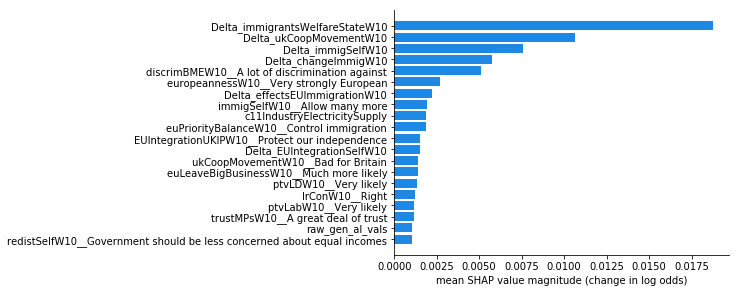

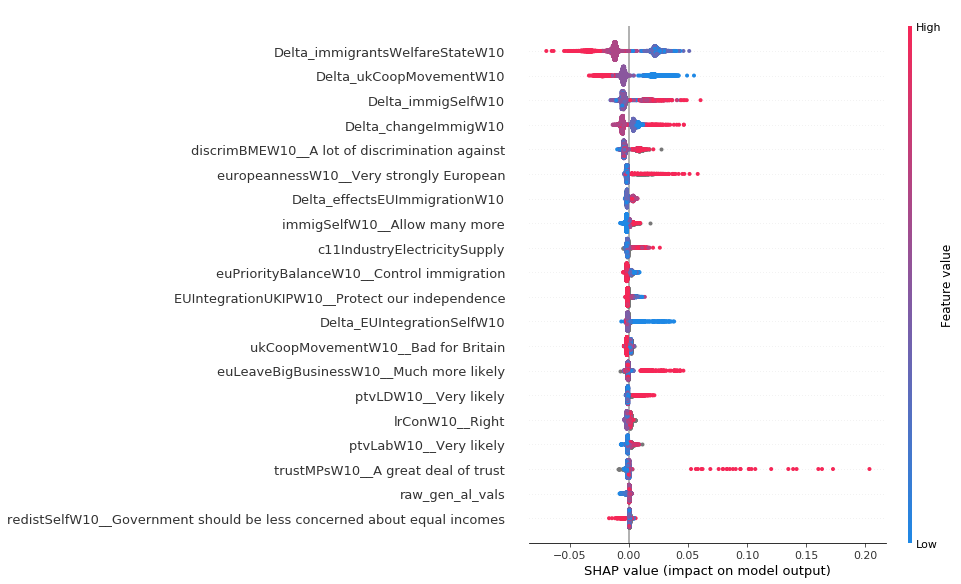

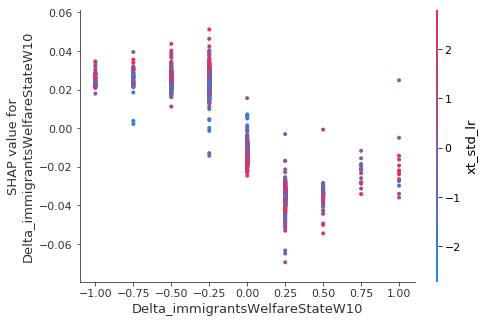

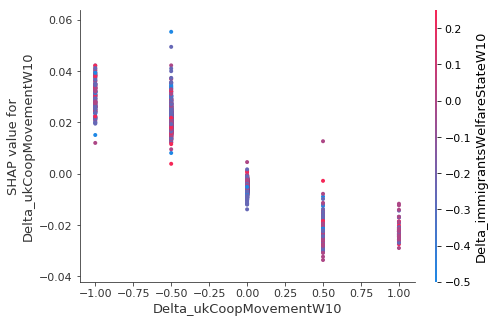

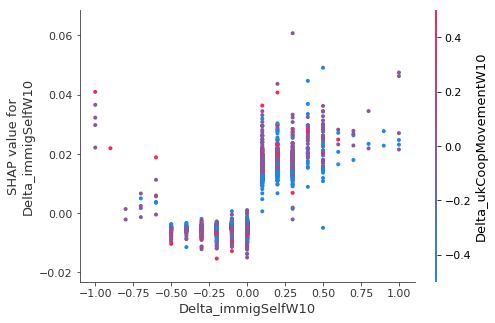

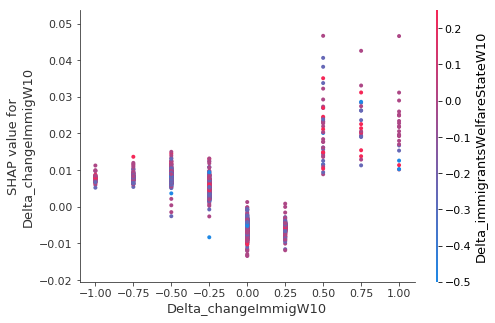

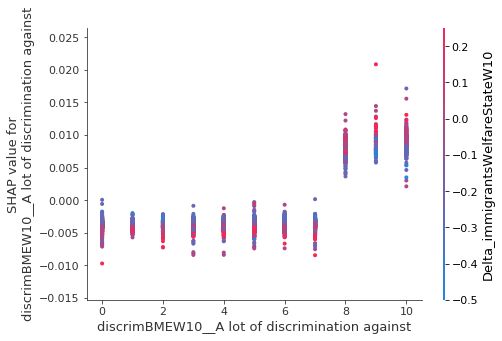

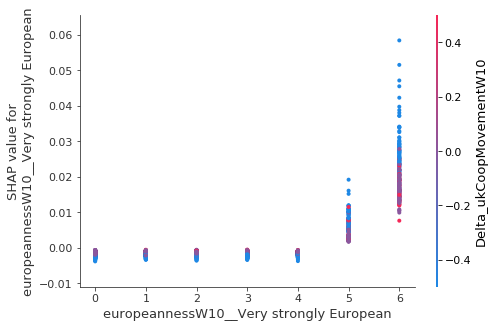

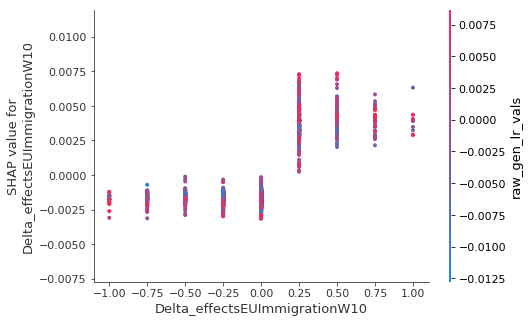

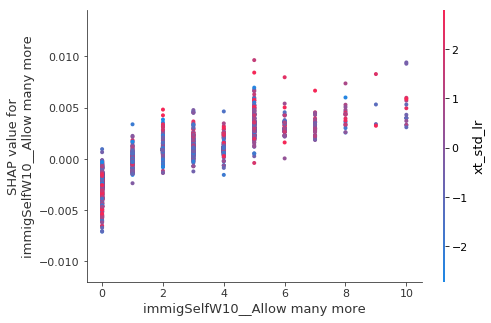

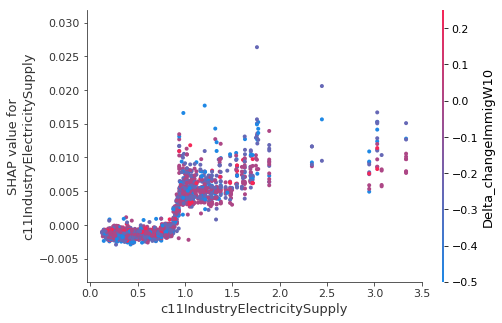

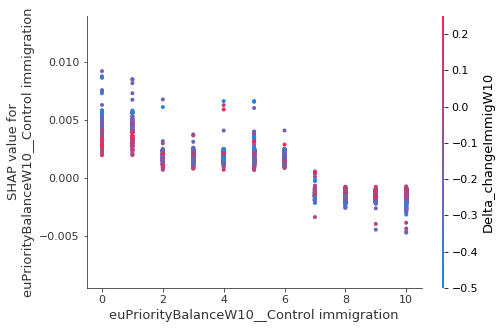

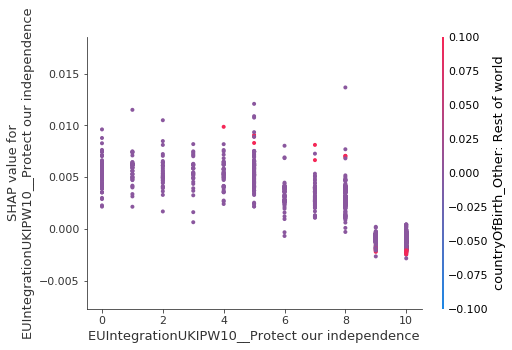

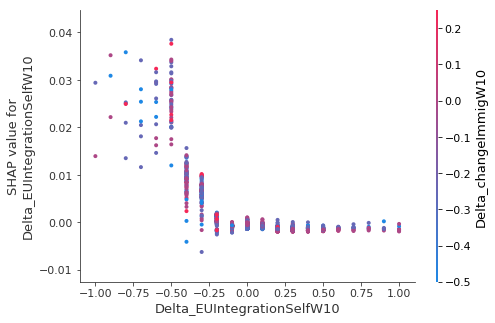

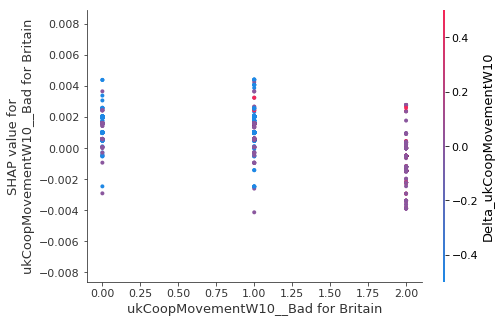

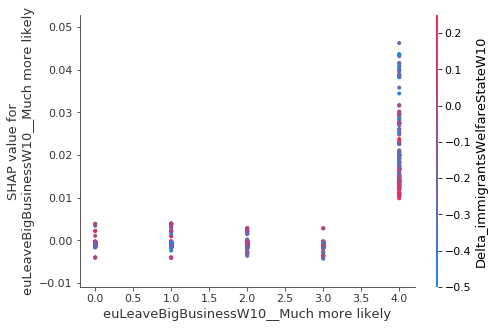

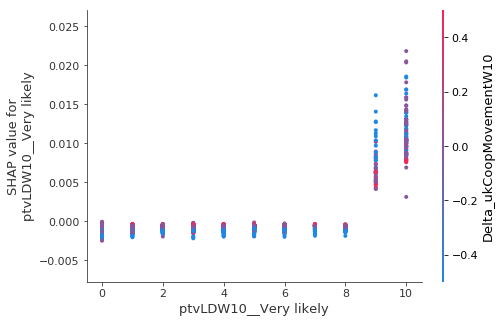

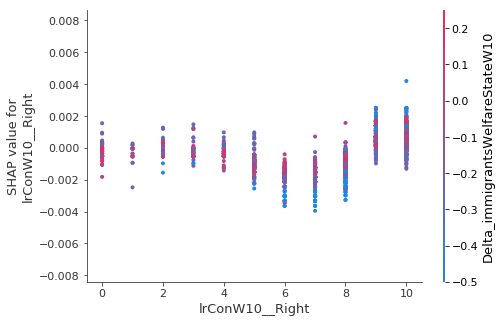

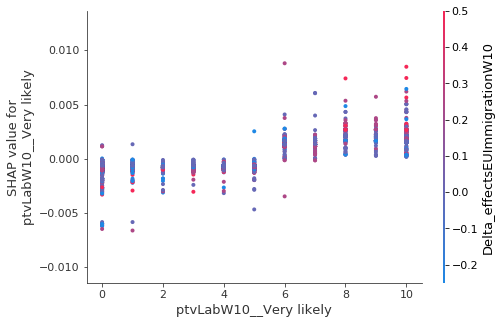

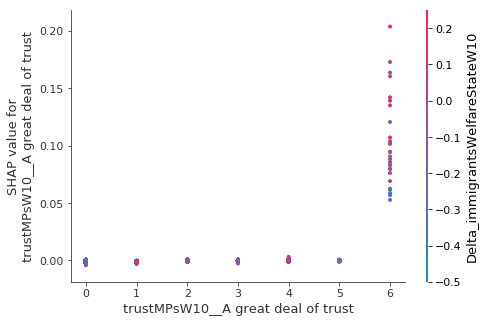

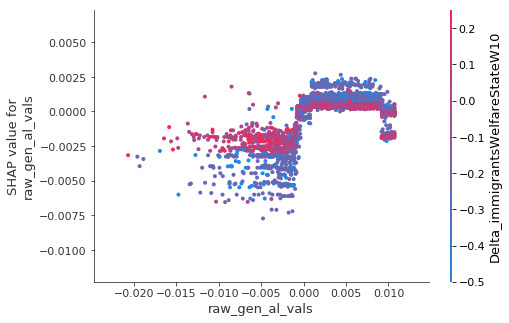

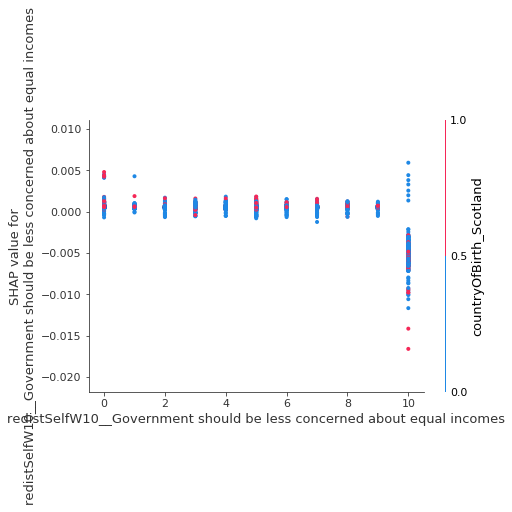

Delta_immigCult_plus_EcW11 11
missing vals in sample weights: 0
[0]	validation_0-rmse:0.480413
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.46353
[2]	validation_0-rmse:0.447446
[3]	validation_0-rmse:0.432046
[4]	validation_0-rmse:0.417251
[5]	validation_0-rmse:0.403246
[6]	validation_0-rmse:0.389894
[7]	validation_0-rmse:0.377399
[8]	validation_0-rmse:0.365351
[9]	validation_0-rmse:0.353895
[10]	validation_0-rmse:0.342853
[11]	validation_0-rmse:0.332414
[12]	validation_0-rmse:0.322587
[13]	validation_0-rmse:0.313305
[14]	validation_0-rmse:0.304394
[15]	validation_0-rmse:0.296061
[16]	validation_0-rmse:0.288053
[17]	validation_0-rmse:0.28051
[18]	validation_0-rmse:0.273506
[19]	validation_0-rmse:0.266788
[20]	validation_0-rmse:0.260491
[21]	validation_0-rmse:0.254482
[22]	validation_0-rmse:0.248898
[23]	validation_0-rmse:0.243642
[24]	validation_0-rmse:0.238814
[25]	validation_0-rmse:0.234039
[26]	validation_0-rmse:0.229678
[27]	validation_

[249]	validation_0-rmse:0.173212
[250]	validation_0-rmse:0.173243
[251]	validation_0-rmse:0.173275
[252]	validation_0-rmse:0.17328
[253]	validation_0-rmse:0.173253
[254]	validation_0-rmse:0.173258
[255]	validation_0-rmse:0.173269
[256]	validation_0-rmse:0.173309
[257]	validation_0-rmse:0.1733
[258]	validation_0-rmse:0.173313
[259]	validation_0-rmse:0.173332
[260]	validation_0-rmse:0.173384
[261]	validation_0-rmse:0.173389
[262]	validation_0-rmse:0.173434
[263]	validation_0-rmse:0.173433
[264]	validation_0-rmse:0.173451
[265]	validation_0-rmse:0.173441
[266]	validation_0-rmse:0.173451
[267]	validation_0-rmse:0.173476
[268]	validation_0-rmse:0.173486
[269]	validation_0-rmse:0.173471
[270]	validation_0-rmse:0.1735
[271]	validation_0-rmse:0.173503
[272]	validation_0-rmse:0.173531
[273]	validation_0-rmse:0.173528
[274]	validation_0-rmse:0.17352
[275]	validation_0-rmse:0.173536
[276]	validation_0-rmse:0.17354
[277]	validation_0-rmse:0.173571
[278]	validation_0-rmse:0.173584
[279]	validation_

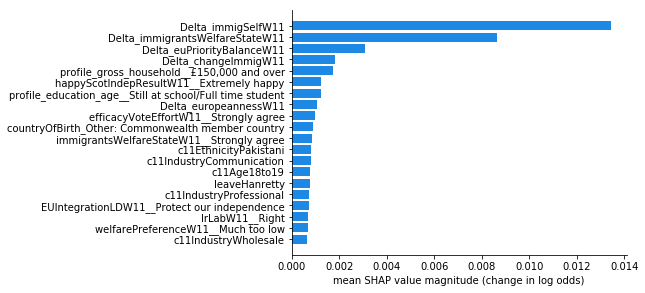

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


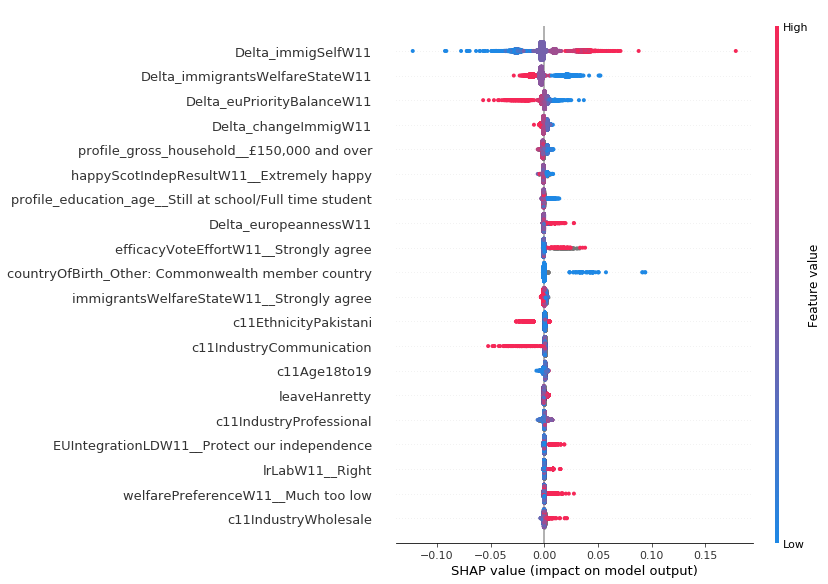

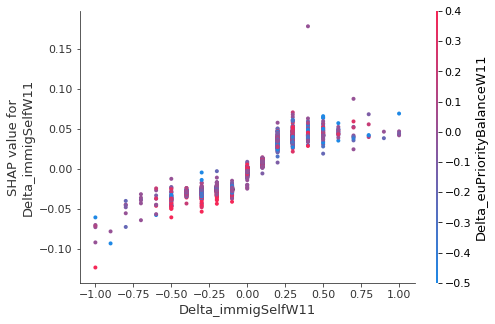

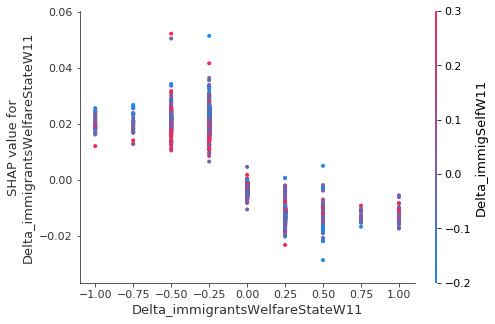

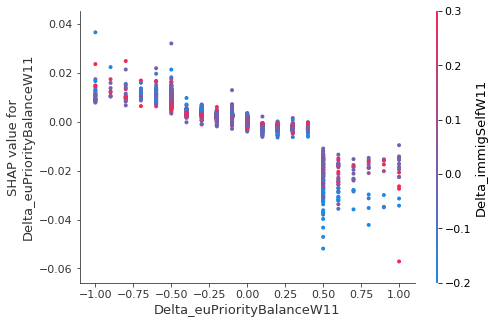

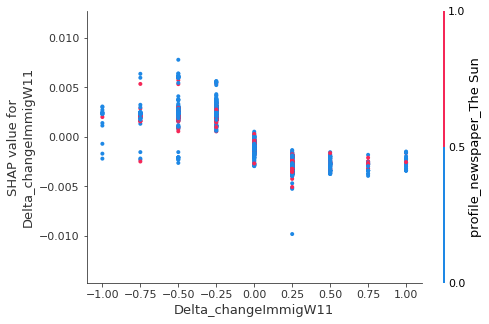

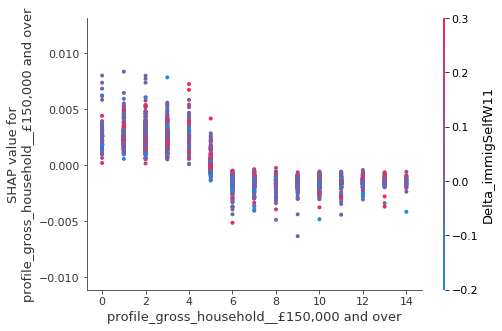

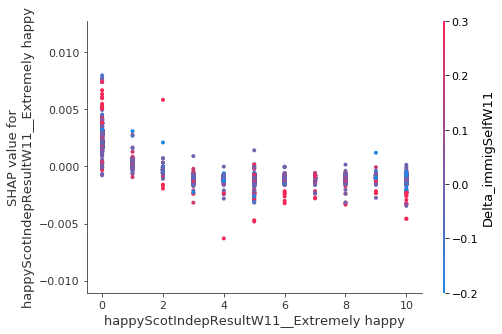

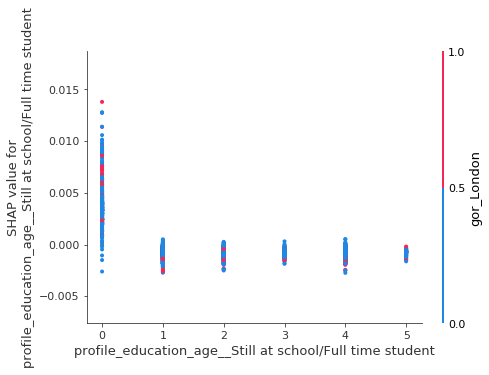

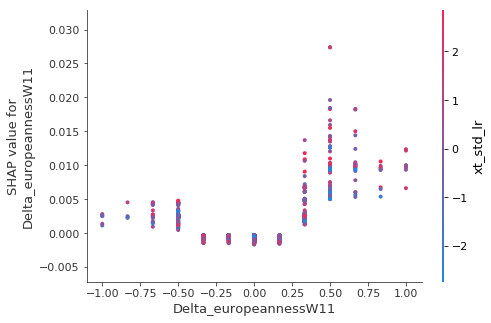

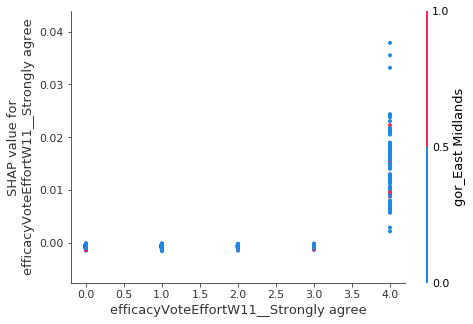

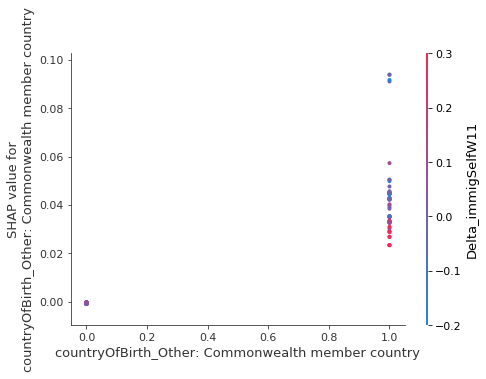

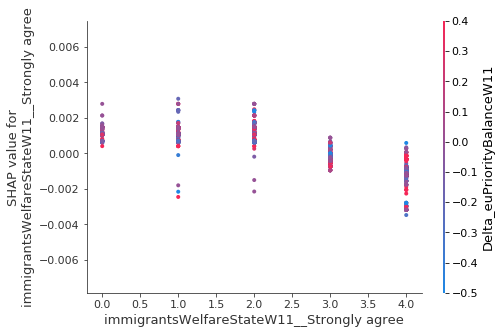

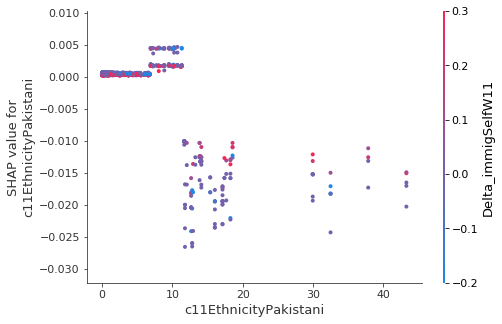

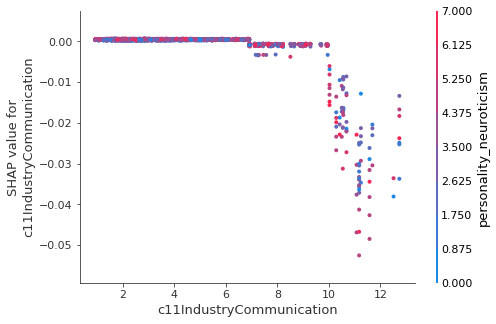

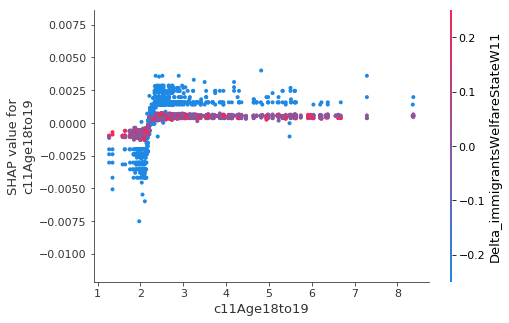

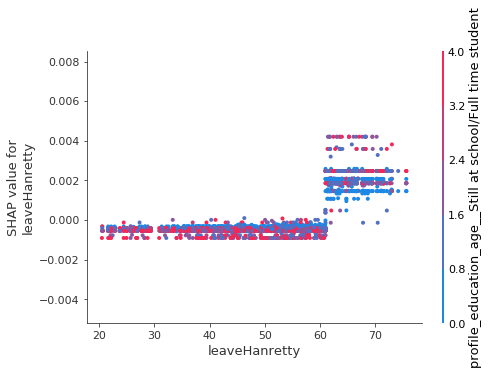

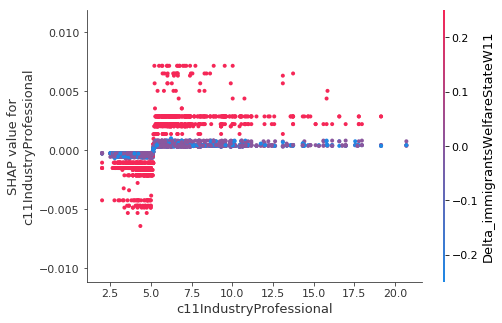

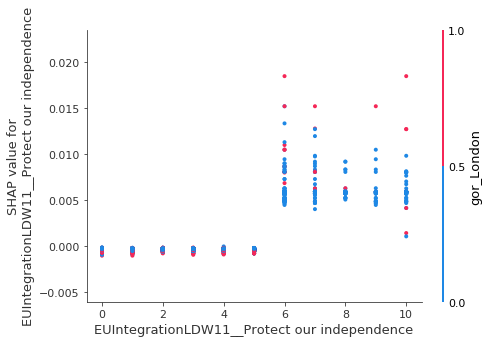

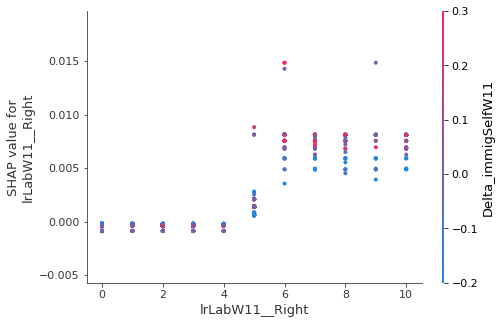

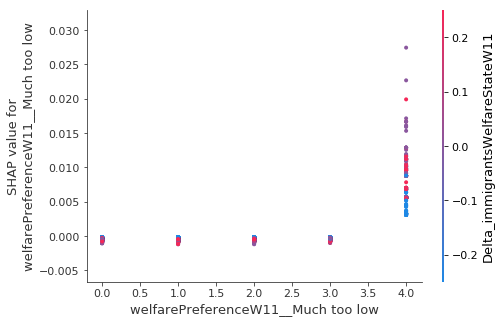

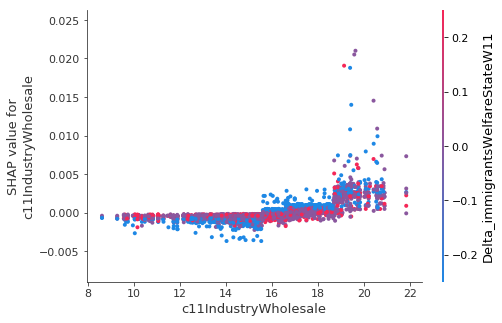

Delta_immigCult_plus_EcW13 13
missing vals in sample weights: 0
[0]	validation_0-rmse:0.530015
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.511155
[2]	validation_0-rmse:0.492929
[3]	validation_0-rmse:0.475732
[4]	validation_0-rmse:0.459277
[5]	validation_0-rmse:0.443624
[6]	validation_0-rmse:0.428607
[7]	validation_0-rmse:0.414419
[8]	validation_0-rmse:0.400932
[9]	validation_0-rmse:0.388012
[10]	validation_0-rmse:0.37578
[11]	validation_0-rmse:0.363887
[12]	validation_0-rmse:0.352769
[13]	validation_0-rmse:0.342118
[14]	validation_0-rmse:0.332019
[15]	validation_0-rmse:0.322484
[16]	validation_0-rmse:0.313363
[17]	validation_0-rmse:0.304702
[18]	validation_0-rmse:0.296502
[19]	validation_0-rmse:0.288673
[20]	validation_0-rmse:0.281304
[21]	validation_0-rmse:0.274309
[22]	validation_0-rmse:0.267578
[23]	validation_0-rmse:0.261342
[24]	validation_0-rmse:0.25534
[25]	validation_0-rmse:0.249669
[26]	validation_0-rmse:0.24439
[27]	validation_0

[249]	validation_0-rmse:0.169023
[250]	validation_0-rmse:0.169034
[251]	validation_0-rmse:0.169027
[252]	validation_0-rmse:0.169039
[253]	validation_0-rmse:0.169037
[254]	validation_0-rmse:0.169069
[255]	validation_0-rmse:0.16907
[256]	validation_0-rmse:0.169059
[257]	validation_0-rmse:0.169073
[258]	validation_0-rmse:0.169074
[259]	validation_0-rmse:0.169064
[260]	validation_0-rmse:0.169076
[261]	validation_0-rmse:0.169096
[262]	validation_0-rmse:0.169137
[263]	validation_0-rmse:0.169161
[264]	validation_0-rmse:0.16916
[265]	validation_0-rmse:0.169154
[266]	validation_0-rmse:0.169153
[267]	validation_0-rmse:0.169192
[268]	validation_0-rmse:0.169167
[269]	validation_0-rmse:0.169192
[270]	validation_0-rmse:0.169156
[271]	validation_0-rmse:0.16918
[272]	validation_0-rmse:0.169184
[273]	validation_0-rmse:0.169203
[274]	validation_0-rmse:0.169225
[275]	validation_0-rmse:0.169237
[276]	validation_0-rmse:0.16925
[277]	validation_0-rmse:0.169262
[278]	validation_0-rmse:0.169251
[279]	validati

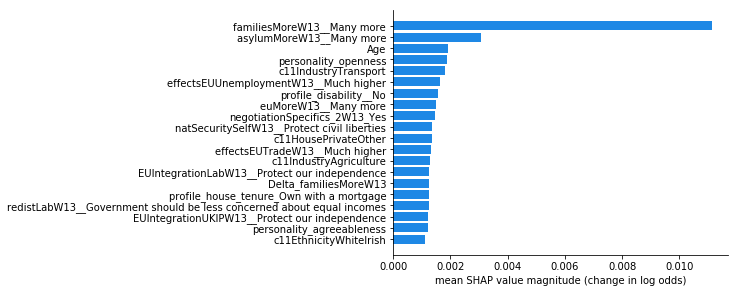

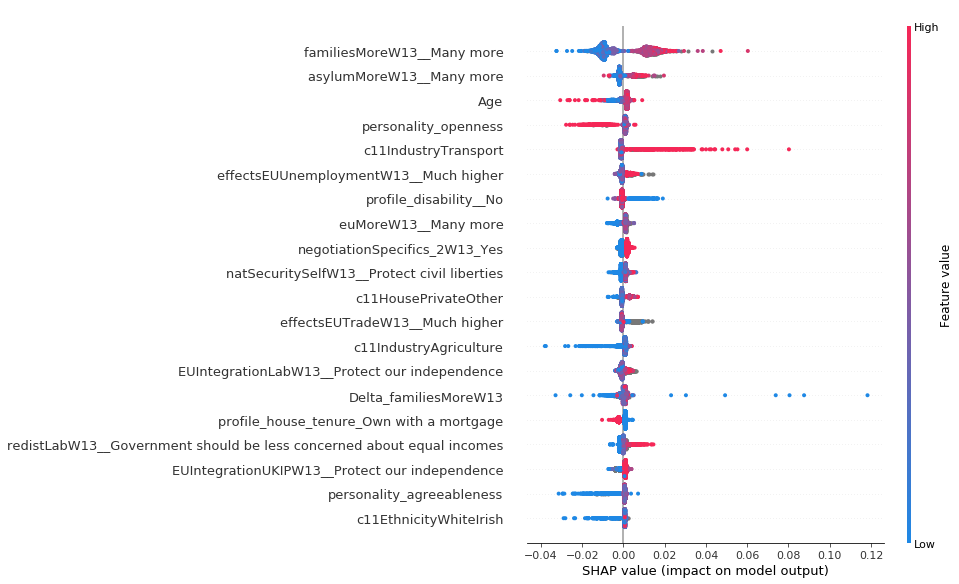

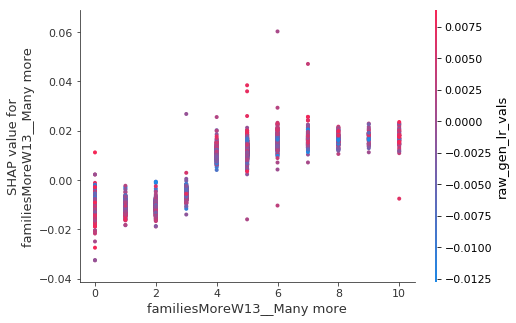

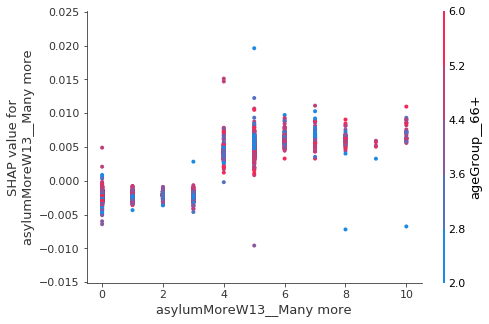

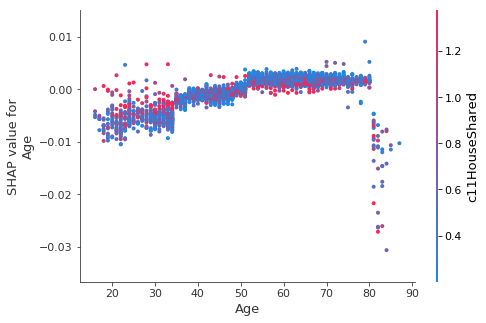

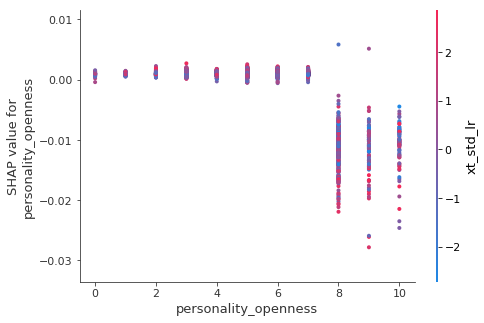

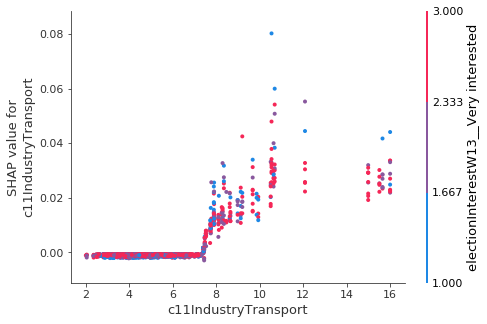

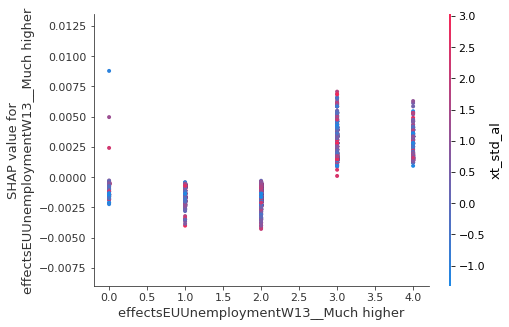

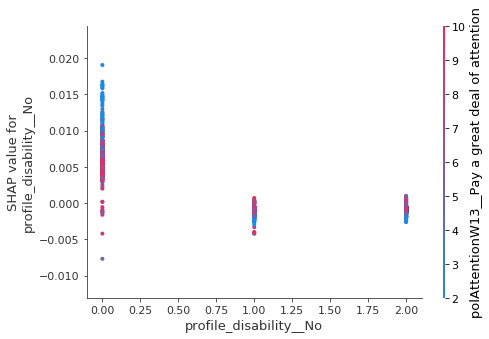

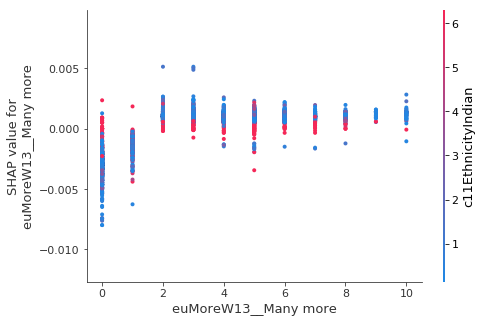

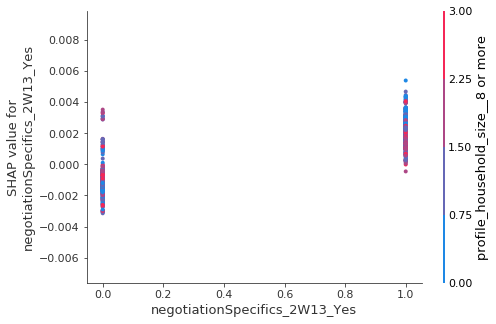

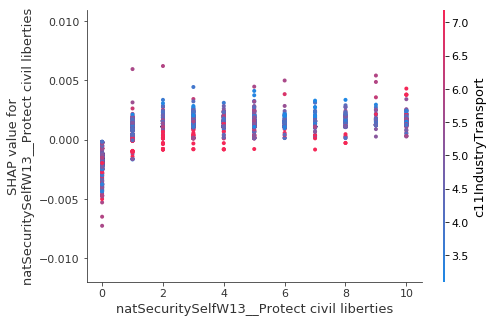

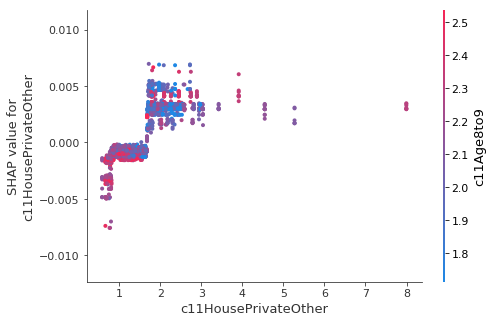

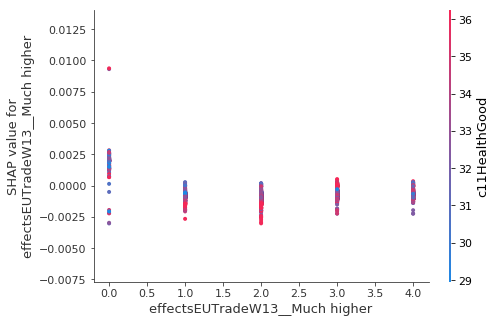

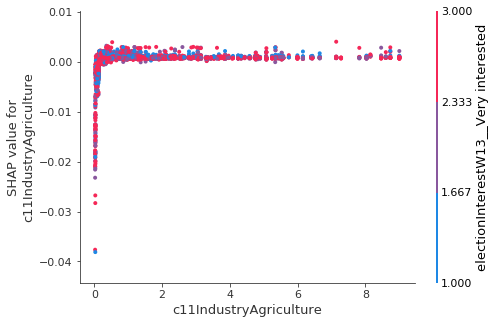

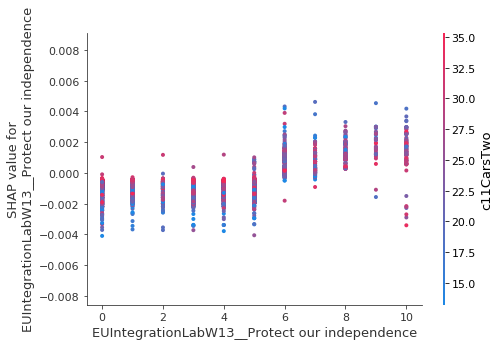

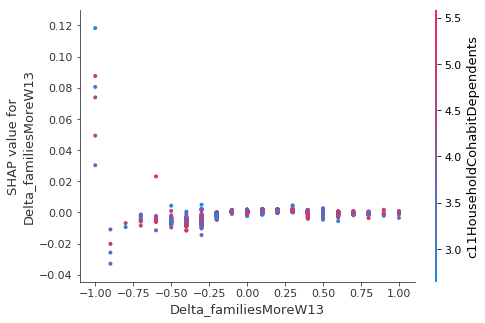

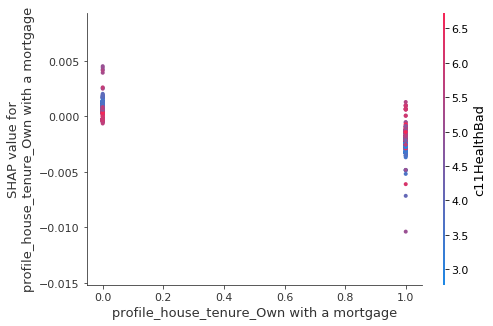

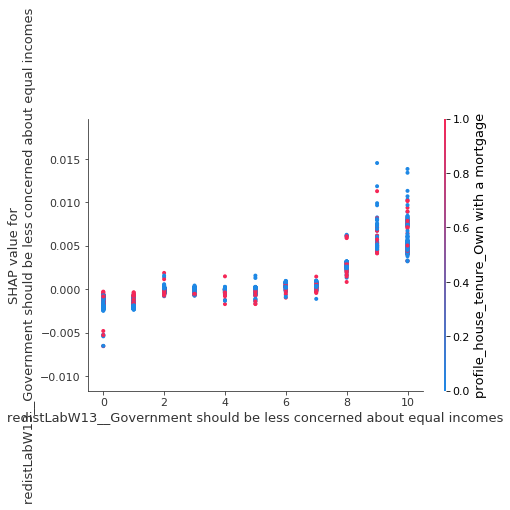

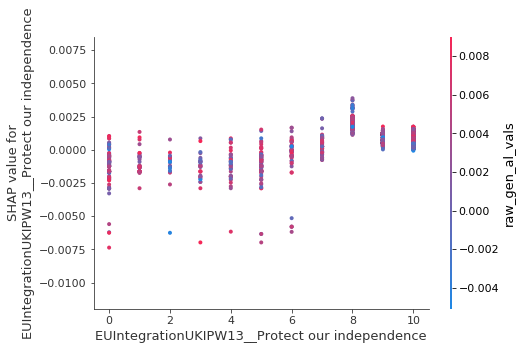

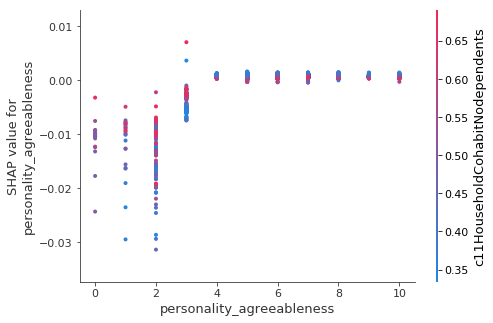

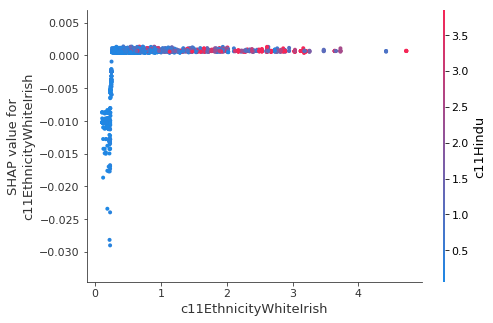

Wall time: 8min 46s


In [281]:
%%time
#     target_var = "immigSelfW10__Allow many more"
# weight_var = 'wt_new_W10'  

num_to_wave = {x:"W"+str(x) for x in range(1,14)}
num_to_weight = { y:[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,14) }
# 'wt_new_W10'

#'wt_full_W9'
# track base variable in list
base_var = 0
for target_var in var_list:
    
#     wave_no = 10
    wave_no = int( re.search( 'W(\d+)$', target_var ).groups()[0] )
    weight_var = num_to_weight[wave_no]
    
    print( target_var, wave_no )
    
#     mask  = immigDiff[target_var].notnull()
#     target = immigDiff[target_var][mask]
#     mask = immigDiff[diff_list ].notnull().all(axis=1)
    mask = immigDiff[target_var].notnull()
    base = BES_reduced_with_na[base_list[base_var]]
    base_var = base_var +1
#     mask = mask & (base >= base.quantile(0.25)) & (base <=base.quantile(0.75))    
    mask = mask & (base <=base.quantile(0.5))
    target = immigDiff[target_var][mask]
#     target = immigDiff[diff_list ].mean(axis=1)[mask]
    
    
    train  = BES_reduced_with_na[mask].copy()
    train = pd.concat([train,immigDiff[mask]],axis=1)
#     train  = train.drop(target_var, axis=1)    
    
#     mask   = changeImmigCultural.notnull()    
#     target = changeImmigCultural[mask]
    
#     train  = train.drop(target_var, axis=1)
    

    
#     mask   = BES_reduced_with_na[target_var].notnull()
#    target = BES_reduced_with_na[target_var][mask]
#     mask   = train[target_var].notnull()
    
    
    # remove zero variance columns
    train  = train.drop(train.columns[train.var()==0], axis=1)
    
    # add pan_dataset_values columns
    train  = pd.concat([train,pan_dataset_values.drop('id',axis=1)[mask]],axis=1)
    train  = train.drop("genImmigSentiment", axis=1)
    
    # drop variables that definitely involve *some* downsteam component - e.g. target is W4, predictor is W6
    
    other_waves = "("+"|".join([num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]) +")" +"([^0-9]|$)"
    train = train.drop( [x for x in train.columns if re.search(other_waves,x)] , axis=1 )   
    
#     for future_wave in [num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]:
#         train = train.drop([x for x in train.columns if re.search(future_wave+"[^0-9]",x)], axis=1)
        
        
#     train = train.drop([x for x in train.columns if ("W10" in x)|("W11" in x)|("W12" in x)|("W13" in x)], axis=1)
    for var_stub in var_stub_list:
        train = train.drop([x for x in train.columns if var_stub in x], axis=1)
    
#     train = train.drop([x for x in train.columns if "immigCultural" in x], axis=1)      
#     train = train.drop([x for x in train.columns if "euRefVote" in x], axis=1)    


    sample_weights = BES_Panel[weight_var][mask]
    print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
    sample_weights = sample_weights.fillna(sample_weights.median())

    output_subfolder = BES_output_folder + "xgboost&shap" + os.sep + target_var + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )


    ############################

    alg = XGBRegressor(
     learning_rate =0.04,
     n_estimators= 2000,
     max_depth=3,
     min_child_weight=1,
     gamma=0,
     subsample=0.75,
     colsample_bytree=0.9,
     colsample_bylevel=.85,
     objective= 'reg:linear',
     scale_pos_weight=1.0,
     reg_alpha=0,
     reg_lambda=1,
     njobs=3,
     seed=27)

    # split data into train and test sets
    # fit, validate and find overfitting limit
    seed = 7
    test_size = 0.33

    X_train, X_test, y_train, y_test = train_test_split(pd.concat([train,sample_weights],axis=1), target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))



    eval_set = [(X_test, y_test)]

    sample_weight = X_train[weight_var].values
    sample_weight_eval_set = X_test[weight_var].values
    X_train.drop(weight_var, axis=1, inplace=True)
    X_test.drop(weight_var, axis=1, inplace=True)

    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True, sample_weight= sample_weight)

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)

    ####################################
    # fit to full dataset at non-overfitting level
    alg.fit(train, target, verbose=True, sample_weight= sample_weights)




    shap_values = shap.TreeExplainer(alg).shap_values(train);


    #################################
    threshold = .1
    min_features = 20
    global_shap_vals = np.abs(shap_values).mean(0)[:-1]
    n_top_features = sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold)
    if n_top_features <min_features:
        n_top_features = min_features



    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig(output_subfolder + "mean_impact" + ".png", bbox_inches='tight')

    plt.show()

    ####################
    fig = plt.figure()
    shap.summary_plot(shap_values, train, max_display=n_top_features, plot_type='dot');
    fig.savefig(output_subfolder + "summary_plot" + ".png", bbox_inches='tight')



    ##################
    count = 0
    for name in train.columns[inds[::-1]]:
        fig = plt.figure(figsize = (16,10))    
        shap.dependence_plot(name, shap_values, train)
        fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_") + ".png", bbox_inches='tight')
        count = count + 1

In [ ]:
# BES_Panel["InequalityChangeW2"]

In [ ]:
# Something we see when including immigSelf:
## Who are these people who think UKIP is in favour of immigration???

# Something we seen only when looking at median-down distribution:
# trustMPs

In [137]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:-1])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:-1])

In [138]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

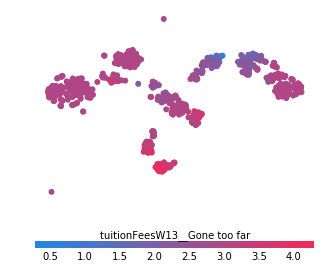

In [141]:
f = plt.figure(figsize=(5,5))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = plt.colorbar(label="tuitionFeesW13__Gone too far", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")
plt.show()

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


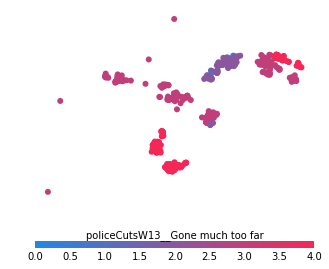

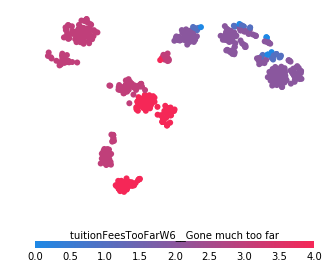

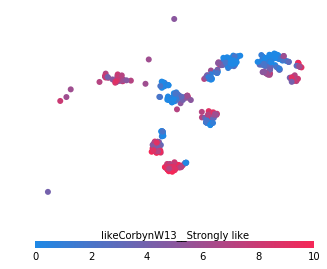

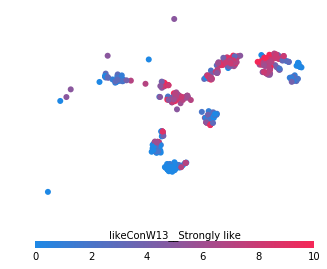

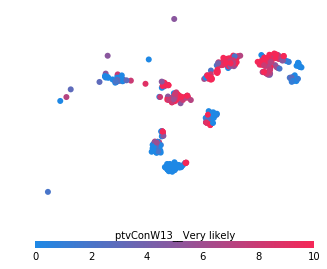

In [143]:
for feature in X.columns[inds[::-1]][0:5]:
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].as_matrix()[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = plt.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    plt.gca().axis("off")
    plt.show()

Index(['policeCutsW13__Gone much too far',
       'tuitionFeesTooFarW6__Gone much too far',
       'likeCorbynW13__Strongly like', 'likeConW13__Strongly like',
       'ptvConW13__Very likely',
       'profile_education_ageW13__Still at school/Full time student',
       'leftRightW13__Right', 'socialCareW13__Own money',
       'handleEUNegotiateW13__Very well', 'al1W13__Strongly agree'],
      dtype='object')

In [ ]:
### xgboost_tuner
# https://github.com/cwerner87/xgboost-tuner

In [18]:
from xgboost_tuner.tuner import tune_xgb_params

In [19]:
train = X.values
label = rounded_targets

In [20]:
# metric_sklearn = ‘neg_mean_squared_error’ or 'remse'
# estimator_cls = xgb.XGBClassifier, xgb.XGBRegressor


# Tune the parameters incrementally and limit the range for colsample_bytree and subsample
best_params, history = tune_xgb_params(
    cv_folds=3,
    label=label,
    metric_sklearn='neg_mean_squared_error',
    metric_xgb="rmse",
    n_jobs=4,
    objective='reg:linear',
    random_state=2017,
    strategy='incremental',
    train=train,
    init_colsample_bytree = 0.9,
    init_gamma = 0.0,
    init_max_depth =3,
    init_min_child_weight  = 1,
    init_subsample = 0.75,
    learning_rates = [0.03,.04,.05],
)

[0]	train-rmse:2.45102+0.0737574	test-rmse:2.44914+0.147594
[1]	train-rmse:2.42397+0.0713214	test-rmse:2.42392+0.147379
[2]	train-rmse:2.39983+0.0700935	test-rmse:2.40084+0.145717
[3]	train-rmse:2.37692+0.0687844	test-rmse:2.37987+0.144134
[4]	train-rmse:2.35561+0.0673367	test-rmse:2.36117+0.142032
[5]	train-rmse:2.33605+0.0658556	test-rmse:2.3432+0.140909
[6]	train-rmse:2.31724+0.0645048	test-rmse:2.32707+0.139404
[7]	train-rmse:2.30101+0.0634925	test-rmse:2.31217+0.138565
[8]	train-rmse:2.28559+0.0623674	test-rmse:2.29851+0.13752
[9]	train-rmse:2.271+0.0616904	test-rmse:2.28542+0.135926
[10]	train-rmse:2.25708+0.0606261	test-rmse:2.27401+0.135455
[11]	train-rmse:2.24422+0.0598278	test-rmse:2.26335+0.134464
[12]	train-rmse:2.23209+0.0590246	test-rmse:2.25329+0.133544
[13]	train-rmse:2.22094+0.0583702	test-rmse:2.24363+0.132238
[14]	train-rmse:2.21031+0.0577832	test-rmse:2.2352+0.130388
[15]	train-rmse:2.2008+0.057766	test-rmse:2.22791+0.129496
[16]	train-rmse:2.19107+0.0578588	test-rm

[136]	train-rmse:1.86682+0.0552879	test-rmse:2.09739+0.108626
[137]	train-rmse:1.86539+0.0551311	test-rmse:2.09734+0.108376
[138]	train-rmse:1.86373+0.0550723	test-rmse:2.09719+0.108465
[139]	train-rmse:1.86218+0.0550981	test-rmse:2.09726+0.108981
[140]	train-rmse:1.8607+0.0551891	test-rmse:2.09738+0.108933
[141]	train-rmse:1.85907+0.0553776	test-rmse:2.09731+0.108867
[142]	train-rmse:1.85744+0.0557611	test-rmse:2.09732+0.108865
[143]	train-rmse:1.85601+0.0556903	test-rmse:2.09732+0.108735
[144]	train-rmse:1.85476+0.0554441	test-rmse:2.09729+0.108291
[145]	train-rmse:1.85354+0.0555736	test-rmse:2.09744+0.108568
[146]	train-rmse:1.85188+0.0555292	test-rmse:2.09712+0.108333
[147]	train-rmse:1.85046+0.0558928	test-rmse:2.09683+0.107863
[148]	train-rmse:1.84913+0.055984	test-rmse:2.09712+0.107863
[149]	train-rmse:1.8476+0.0560793	test-rmse:2.0971+0.107952
[150]	train-rmse:1.84602+0.0561478	test-rmse:2.09712+0.107976
[151]	train-rmse:1.84459+0.0564787	test-rmse:2.0971+0.107835
[152]	train-r

[269]	train-rmse:1.69488+0.0595683	test-rmse:2.09545+0.102917
[270]	train-rmse:1.69376+0.0595124	test-rmse:2.09523+0.103116
[271]	train-rmse:1.69267+0.0597155	test-rmse:2.09496+0.103035
[272]	train-rmse:1.69177+0.0593639	test-rmse:2.09507+0.103094
[273]	train-rmse:1.69071+0.0596524	test-rmse:2.09511+0.103014
[274]	train-rmse:1.68948+0.0596898	test-rmse:2.09538+0.102813
[275]	train-rmse:1.68838+0.05978	test-rmse:2.09531+0.102686
[276]	train-rmse:1.68721+0.0596851	test-rmse:2.09518+0.102636
[277]	train-rmse:1.68603+0.0597494	test-rmse:2.09525+0.102591
[278]	train-rmse:1.68466+0.0595897	test-rmse:2.09529+0.102613
[279]	train-rmse:1.68338+0.0594009	test-rmse:2.09556+0.102899
[280]	train-rmse:1.68225+0.0593571	test-rmse:2.09591+0.10325
[281]	train-rmse:1.68115+0.0592578	test-rmse:2.09609+0.103423
[282]	train-rmse:1.68026+0.0593247	test-rmse:2.09599+0.103339
[283]	train-rmse:1.67905+0.0594623	test-rmse:2.09619+0.103149
[284]	train-rmse:1.67781+0.0593588	test-rmse:2.09589+0.103266
Fitting 3 f

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 12.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 16.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 21.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 27.8min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 36.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 45.5min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 57.4min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 71.0min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 87.1min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 95.4min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed:  4.2min remaining:  1.6min
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:  5.2min remaining:  1.0min
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  6.1min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 13.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 16.9min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 20.5min finished


Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.6min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed: 15.5min finished


Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed: 15.4min finished


[0]	train-rmse:2.45622+0.0743227	test-rmse:2.45425+0.147389
[1]	train-rmse:2.43454+0.072185	test-rmse:2.43367+0.146881
[2]	train-rmse:2.41437+0.0711869	test-rmse:2.41383+0.145233
[3]	train-rmse:2.39502+0.0698438	test-rmse:2.39596+0.144477
[4]	train-rmse:2.37666+0.0684067	test-rmse:2.37936+0.143885
[5]	train-rmse:2.35946+0.0671209	test-rmse:2.36392+0.143398
[6]	train-rmse:2.34342+0.0659682	test-rmse:2.34945+0.14208
[7]	train-rmse:2.32865+0.0654404	test-rmse:2.3363+0.14086
[8]	train-rmse:2.31501+0.0648707	test-rmse:2.32383+0.139833
[9]	train-rmse:2.30165+0.0641198	test-rmse:2.31236+0.138989
[10]	train-rmse:2.28912+0.0630499	test-rmse:2.30142+0.138761
[11]	train-rmse:2.27722+0.0622342	test-rmse:2.29074+0.137787
[12]	train-rmse:2.26568+0.0616441	test-rmse:2.28081+0.136872
[13]	train-rmse:2.25518+0.061112	test-rmse:2.27156+0.136211
[14]	train-rmse:2.245+0.0603395	test-rmse:2.26311+0.135091
[15]	train-rmse:2.23547+0.0595014	test-rmse:2.25489+0.134595
[16]	train-rmse:2.22638+0.0593149	test-rm

[136]	train-rmse:1.91282+0.0567545	test-rmse:2.1029+0.111059
[137]	train-rmse:1.91161+0.0568921	test-rmse:2.10286+0.110882
[138]	train-rmse:1.91026+0.0570307	test-rmse:2.10276+0.111064
[139]	train-rmse:1.90891+0.0571297	test-rmse:2.10267+0.111106
[140]	train-rmse:1.90775+0.0569787	test-rmse:2.10252+0.110909
[141]	train-rmse:1.90635+0.0570144	test-rmse:2.10238+0.110931
[142]	train-rmse:1.90485+0.0569157	test-rmse:2.10202+0.110833
[143]	train-rmse:1.90368+0.0569717	test-rmse:2.10183+0.110576
[144]	train-rmse:1.90241+0.0567585	test-rmse:2.10168+0.110376
[145]	train-rmse:1.90109+0.056693	test-rmse:2.10129+0.11021
[146]	train-rmse:1.89978+0.0567021	test-rmse:2.10135+0.110094
[147]	train-rmse:1.89852+0.0567276	test-rmse:2.10118+0.109918
[148]	train-rmse:1.89714+0.0567655	test-rmse:2.10142+0.109847
[149]	train-rmse:1.89596+0.056676	test-rmse:2.10124+0.109937
[150]	train-rmse:1.89481+0.0567544	test-rmse:2.10074+0.110029
[151]	train-rmse:1.89348+0.0568623	test-rmse:2.10072+0.110057
[152]	train-

[269]	train-rmse:1.76146+0.060964	test-rmse:2.09599+0.112537
[270]	train-rmse:1.76062+0.0608181	test-rmse:2.09573+0.112734
[271]	train-rmse:1.75981+0.0611206	test-rmse:2.0958+0.112742
[272]	train-rmse:1.75894+0.061232	test-rmse:2.09599+0.113197
[273]	train-rmse:1.75791+0.0610673	test-rmse:2.09588+0.113463
[274]	train-rmse:1.757+0.0610702	test-rmse:2.09608+0.11359
[275]	train-rmse:1.75591+0.0610958	test-rmse:2.09654+0.113732
[276]	train-rmse:1.75499+0.0612236	test-rmse:2.09662+0.113713
[277]	train-rmse:1.75385+0.0612121	test-rmse:2.0964+0.113533
[278]	train-rmse:1.7529+0.0613174	test-rmse:2.09641+0.113749
[279]	train-rmse:1.75198+0.061342	test-rmse:2.09655+0.113407
[280]	train-rmse:1.75112+0.0613353	test-rmse:2.09628+0.113322
[281]	train-rmse:1.75021+0.0614452	test-rmse:2.09628+0.113207
[282]	train-rmse:1.74909+0.0615161	test-rmse:2.09653+0.113207
[283]	train-rmse:1.74826+0.0615698	test-rmse:2.09661+0.113201
[284]	train-rmse:1.7473+0.0613087	test-rmse:2.0966+0.113181
[285]	train-rmse:1.

[110]	train-rmse:1.99738+0.0537972	test-rmse:2.11885+0.110409
[111]	train-rmse:1.99602+0.0537064	test-rmse:2.11853+0.1105
[112]	train-rmse:1.99468+0.0536306	test-rmse:2.11809+0.11051
[113]	train-rmse:1.99338+0.0536447	test-rmse:2.11771+0.110303
[114]	train-rmse:1.99208+0.0537653	test-rmse:2.11719+0.109879
[115]	train-rmse:1.99103+0.0537491	test-rmse:2.11715+0.109662
[116]	train-rmse:1.98974+0.0536754	test-rmse:2.11676+0.109742
[117]	train-rmse:1.98844+0.0535815	test-rmse:2.11622+0.109666
[118]	train-rmse:1.98715+0.0536414	test-rmse:2.11599+0.109603
[119]	train-rmse:1.98592+0.0536092	test-rmse:2.1159+0.1096
[120]	train-rmse:1.98464+0.0535899	test-rmse:2.11556+0.109633
[121]	train-rmse:1.98325+0.0534797	test-rmse:2.11502+0.109773
[122]	train-rmse:1.98205+0.0534011	test-rmse:2.11479+0.109396
[123]	train-rmse:1.9809+0.0534657	test-rmse:2.11445+0.109448
[124]	train-rmse:1.9796+0.0534724	test-rmse:2.11409+0.109648
[125]	train-rmse:1.97836+0.0534792	test-rmse:2.11357+0.109552
[126]	train-rmse

[244]	train-rmse:1.85346+0.0562656	test-rmse:2.09826+0.107854
[245]	train-rmse:1.85262+0.0561121	test-rmse:2.09813+0.107977
[246]	train-rmse:1.85185+0.0562293	test-rmse:2.0981+0.107818
[247]	train-rmse:1.85091+0.0563587	test-rmse:2.09819+0.107949
[248]	train-rmse:1.85024+0.0564577	test-rmse:2.0981+0.10769
[249]	train-rmse:1.84932+0.0564218	test-rmse:2.09821+0.107611
[250]	train-rmse:1.84839+0.0564508	test-rmse:2.09826+0.10777
[251]	train-rmse:1.84757+0.056455	test-rmse:2.09811+0.107785
[252]	train-rmse:1.84675+0.0565556	test-rmse:2.09808+0.10777
[253]	train-rmse:1.8458+0.0565058	test-rmse:2.09803+0.107671
[254]	train-rmse:1.84492+0.0563949	test-rmse:2.09807+0.107761
[255]	train-rmse:1.84409+0.0563858	test-rmse:2.09806+0.107683
[256]	train-rmse:1.84315+0.0563559	test-rmse:2.0983+0.107953
[257]	train-rmse:1.84231+0.0564303	test-rmse:2.09804+0.107771
[258]	train-rmse:1.84143+0.0564763	test-rmse:2.09809+0.107775
[259]	train-rmse:1.84052+0.056579	test-rmse:2.09792+0.107589
[260]	train-rmse:

[378]	train-rmse:1.74831+0.0588445	test-rmse:2.0969+0.10808
[379]	train-rmse:1.74753+0.0589606	test-rmse:2.09721+0.108326


In [21]:
history

[({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 1,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 2017,
   'n_estimators': 236},
  1.734541),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 1,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 2017,
   'n_estimators': 236},
  2.102119888805619),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 1,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 2017,
   'n_estimators': 236},
  2.1021192355810046),
 ({'colsample_bytree': 0.9,
   'gamma': 0.1,
   'learning_rate': 0.05,
   'max_depth': 3,
   'min_child_weight': 1,
   'nthread': 1,
   'objective': 'reg:linea

In [22]:
best_params

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'nthread': 4,
 'objective': 'reg:linear',
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'random_state': 2017,
 'n_estimators': 236,
 'reg_alpha': 0.0001,
 'reg_lambda': 1}

In [36]:
X["wt_new_W10"].mean()

0.9821956499492163

In [ ]:
# %%time
## manual test

weight_var = "wt_new_W10"
target = rounded_targets

seed = 7
test_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=test_size,
                                                    random_state=seed, stratify=target)
alg = XGBRegressor(
 learning_rate =0.04,
 n_estimators= 500,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 seed=27)

# {'colsample_bytree': 0.9,
#  'gamma': 0.0,
#  'learning_rate': 0.05,
#  'max_depth': 3,
#  'min_child_weight': 1,
#  'reg_alpha': 0,
#  'subsample': 0.9}

param_test1 ={
 'max_depth':[3],
 'min_child_weight':[1],
 'learning_rate':[0.045,0.055],
 'subsample':[0.85,.95],
 'colsample_bytree':[0.85,.95],

}

eval_set = [(X_test, y_test)]

sample_weight = X_train[weight_var].values
sample_weight_eval_set = X_test[weight_var].values
X_train.drop(weight_var, axis=1, inplace=True)
X_test.drop(weight_var, axis=1, inplace=True)

# alg.fit(X_train, y_train, eval_metric='rmse', 
#         early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
#         verbose=True, sample_weight= sample_weight)


skf = StratifiedKFold(n_splits=3)

gsearch1 = GridSearchCV(estimator = alg,
                        param_grid = param_test1,
                        scoring='neg_mean_squared_error', #'r2'
                        n_jobs=4, 
                        iid=False,
                        cv=skf,
                        verbose=True)

gsearch1.fit(X,label, eval_metric='rmse', 
        early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
        verbose=True, sample_weight= sample_weight)

display(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

# 500 estimators
# [mean: 0.17896, std: 0.02184, params: {'max_depth': 3, 'min_child_weight': 1}]
# {'max_depth': 3, 'min_child_weight': 1}
# 0.1789614177574044
# Wall time: 8min 31s

# 50 estimators
# {'colsample_bytree': 0.9,
#  'gamma': 0.0,
#  'learning_rate': 0.05,
#  'max_depth': 3,
#  'min_child_weight': 1,
#  'reg_alpha': 0,
#  'subsample': 0.9}
# 0.15092626253619063
# Wall time: 11min 39s

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [23]:
%%time
## manual test
from xgboost_tuner.tuner import tune_xgb_params
weight_var = "wt_new_W10"
target = rounded_targets

seed = 7
test_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=test_size,
                                                    random_state=seed, stratify=target)
alg = XGBRegressor(
 learning_rate =0.04,
 n_estimators= 500,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 seed=27)

# {'colsample_bytree': 0.9,
#  'gamma': 0.0,
#  'learning_rate': 0.05,
#  'max_depth': 3,
#  'min_child_weight': 1,
#  'reg_alpha': 0,
#  'subsample': 0.9}

# {'colsample_bytree': 0.95, 'learning_rate': 0.045, 'subsample': 0.95}

param_test1 ={
#  'max_depth':[3],
#  'min_child_weight':[1],
 'learning_rate':[0.04,0.05],
 'subsample':[0.9,1.0],
 'colsample_bytree':[1.0,.9],

}

eval_set = [(X_test, y_test)]

# sample_weight = X_train[weight_var].values
# sample_weight_eval_set = X_test[weight_var].values
# X_train.drop(weight_var, axis=1, inplace=True)
# X_test.drop(weight_var, axis=1, inplace=True)



skf = StratifiedKFold(n_splits=3)

gsearch1 = GridSearchCV(estimator = alg,
                        param_grid = param_test1,
                        scoring='r2', #'r2'
                        n_jobs=4, 
                        iid=False,
                        cv=skf,
                        verbose=True)

gsearch1.fit(X,target, eval_metric='logloss', 
        early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set)#,
#         verbose=True, sample_weight= sample_weight)

display(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

# 500 estimators
# [mean: 0.17896, std: 0.02184, params: {'max_depth': 3, 'min_child_weight': 1}]
# {'max_depth': 3, 'min_child_weight': 1}
# 0.1789614177574044
# Wall time: 8min 31s

# 50 estimators
# {'colsample_bytree': 0.9,
#  'gamma': 0.0,
#  'learning_rate': 0.05,
#  'max_depth': 3,
#  'min_child_weight': 1,
#  'reg_alpha': 0,
#  'subsample': 0.9}
# 0.15092626253619063
# Wall time: 11min 39s

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed: 13.9min finished


[0]	validation_0-logloss:0.463725
Will train until validation_0-logloss hasn't improved in 50.0 rounds.
[1]	validation_0-logloss:0.239006
[2]	validation_0-logloss:-0.348523
[3]	validation_0-logloss:-1.03165
[4]	validation_0-logloss:-2.53663
[5]	validation_0-logloss:-4.38016
[6]	validation_0-logloss:-7.58056
[7]	validation_0-logloss:-11.3466
[8]	validation_0-logloss:-13.8199
[9]	validation_0-logloss:-14.6489
[10]	validation_0-logloss:-15.1781
[11]	validation_0-logloss:-15.3059
[12]	validation_0-logloss:-15.7233
[13]	validation_0-logloss:-16.082
[14]	validation_0-logloss:-16.9046
[15]	validation_0-logloss:-17.6908
[16]	validation_0-logloss:-18.1059
[17]	validation_0-logloss:-18.6809
[18]	validation_0-logloss:-18.8615
[19]	validation_0-logloss:-19.2918
[20]	validation_0-logloss:-19.4548
[21]	validation_0-logloss:-19.5599
[22]	validation_0-logloss:-19.8208
[23]	validation_0-logloss:-19.7643
[24]	validation_0-logloss:-19.8474
[25]	validation_0-logloss:-19.899
[26]	validation_0-logloss:-20.1

[230]	validation_0-logloss:-24.7138
[231]	validation_0-logloss:-24.7205
[232]	validation_0-logloss:-24.7642
[233]	validation_0-logloss:-24.7307
[234]	validation_0-logloss:-24.8262
[235]	validation_0-logloss:-24.84
[236]	validation_0-logloss:-24.8569
[237]	validation_0-logloss:-24.9494
[238]	validation_0-logloss:-24.9922
[239]	validation_0-logloss:-24.9472
[240]	validation_0-logloss:-24.9554
[241]	validation_0-logloss:-24.9691
[242]	validation_0-logloss:-25.0619
[243]	validation_0-logloss:-25.0922
[244]	validation_0-logloss:-25.2247
[245]	validation_0-logloss:-25.2038
[246]	validation_0-logloss:-25.3021
[247]	validation_0-logloss:-25.3304
[248]	validation_0-logloss:-25.3445
[249]	validation_0-logloss:-25.3229
[250]	validation_0-logloss:-25.3499
[251]	validation_0-logloss:-25.362
[252]	validation_0-logloss:-25.3558
[253]	validation_0-logloss:-25.4218
[254]	validation_0-logloss:-25.4352
[255]	validation_0-logloss:-25.437
[256]	validation_0-logloss:-25.4451
[257]	validation_0-logloss:-25.4

[459]	validation_0-logloss:-28.5098
[460]	validation_0-logloss:-28.5471
[461]	validation_0-logloss:-28.536
[462]	validation_0-logloss:-28.5366
[463]	validation_0-logloss:-28.5711
[464]	validation_0-logloss:-28.5487
[465]	validation_0-logloss:-28.5592
[466]	validation_0-logloss:-28.5506
[467]	validation_0-logloss:-28.6121
[468]	validation_0-logloss:-28.6506
[469]	validation_0-logloss:-28.6533
[470]	validation_0-logloss:-28.5853
[471]	validation_0-logloss:-28.5688
[472]	validation_0-logloss:-28.5851
[473]	validation_0-logloss:-28.6236
[474]	validation_0-logloss:-28.6389
[475]	validation_0-logloss:-28.6382
[476]	validation_0-logloss:-28.7792
[477]	validation_0-logloss:-28.7572
[478]	validation_0-logloss:-28.7457
[479]	validation_0-logloss:-28.7975
[480]	validation_0-logloss:-28.8243
[481]	validation_0-logloss:-28.8014
[482]	validation_0-logloss:-28.8657
[483]	validation_0-logloss:-28.917
[484]	validation_0-logloss:-28.9691
[485]	validation_0-logloss:-28.9828
[486]	validation_0-logloss:-28

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.07278, std: 0.14752, params: {'colsample_bytree': 1.0, 'learning_rate': 0.04, 'subsample': 0.9},
 mean: 0.07469, std: 0.14621, params: {'colsample_bytree': 1.0, 'learning_rate': 0.04, 'subsample': 1.0},
 mean: -0.01176, std: 0.26353, params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'subsample': 0.9},
 mean: -0.01130, std: 0.25054, params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'subsample': 1.0},
 mean: 0.01783, std: 0.22142, params: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'subsample': 0.9},
 mean: 0.07528, std: 0.14088, params: {'colsample_bytree': 0.9, 'learning_rate': 0.04, 'subsample': 1.0},
 mean: 0.00844, std: 0.22984, params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'subsample': 0.9},
 mean: 0.00408, std: 0.23543, params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'subsample': 1.0}]

{'colsample_bytree': 0.9, 'learning_rate': 0.04, 'subsample': 1.0}

0.07528484153422599

Wall time: 16min 58s


In [24]:
gsearch1.best_estimator_.best_iteration

492